# Estimation of tree height using GEDI dataset - Neural Network Feed Forward - 2023

    
    jupyter-notebook   Tree_Height_07FeedForward_Networks_2023.ipynb
    
Use pip3 for the installation

    pip3 install pytorch torchvision torchaudio scikit-learn pandas


We did not use conda anyway pip3 should do the same....try

In [1]:
'''
Packages

conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
conda install -c anaconda scikit-learn
conda install pandas
'''

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import pearsonr


"""
Fix random seeds.
"""
seed=31
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
predictors = pd.read_csv("./tree_height_2/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude'} , axis='columns')
predictors.head(10)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


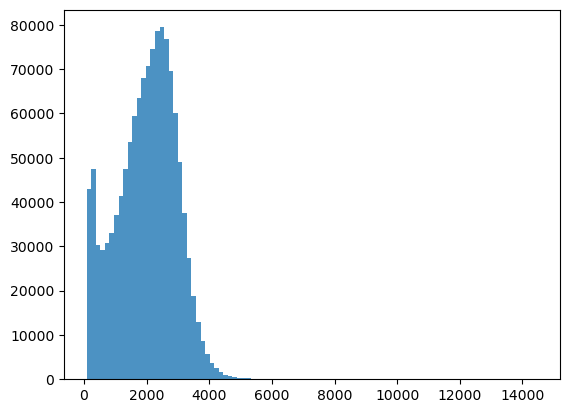

In [3]:
bins = np.linspace(min(predictors['h']),max(predictors['h']),100)
plt.hist((predictors['h']),bins,alpha=0.8);

In [4]:
predictors_sel = predictors.loc[(predictors['h'] < 7000)  ].sample(100000)
predictors_sel.insert ( 4, 'hm' ,  predictors_sel['h']/100 ) # add a culumn of heigh in meter
len(predictors_sel)
predictors_sel.head(10)

,ID,X,Y,h,hm,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
706027,706028,8.142676,49.473039,2192.25,21.9225,1506,12,1951,6332,33.326790,-123652624,-0.773497,-0.098556,264.291107,20,-124.898438,-166.341064,-138.483887,-0.033544,11,670987,17.290588,461.153107,85
311603,311604,7.013065,49.703660,343.00,3.4300,1384,12,2356,5661,-25.426283,-245676352,2.994771,0.006374,654.403931,5,1108.965820,746.828125,661.711182,-0.050651,21,817030,23.282337,414.707062,75
678298,678299,7.976119,48.864294,2000.75,20.0075,1509,11,2297,6539,39.657501,712222848,-1.524940,0.000425,128.738113,14,633.487549,503.831787,528.050537,0.004593,9,760668,19.584862,497.715546,78
574438,574439,7.675911,48.970574,2450.00,24.5000,1519,14,2393,6316,25.545052,45228972,-0.508573,0.016525,269.375000,26,844.863037,247.661865,466.090088,0.038866,8,812785,17.917974,465.584839,99
629555,629556,7.832786,49.434854,1655.75,16.5575,1501,11,1894,6390,-1.106694,-329245536,0.693265,-0.175357,305.205170,25,69.657959,59.458008,-60.963135,-0.101222,8,641305,18.297518,458.570312,85
24779,24780,6.120472,49.359733,2131.00,21.3100,1537,18,1997,6106,-5.047365,-169883136,-1.281423,-0.060032,194.458313,23,118.437012,52.685547,278.717041,0.020525,6,764430,21.795704,478.565186,87
1131458,1131459,9.422926,49.091389,2697.25,26.9725,1524,11,2720,6380,48.204334,207834704,-0.667805,-0.053927,439.546326,24,120.082275,98.926758,-173.800537,0.030877,7,861697,18.758785,467.858246,87
55515,55516,6.236967,49.744940,1998.00,19.9800,1522,12,2220,5868,13.136125,-241940960,0.944569,0.107422,360.844513,25,35.600098,79.752441,287.183594,-0.032823,20,743874,19.420862,445.672028,85
768590,768591,8.487635,48.828276,2386.00,23.8600,1498,17,2951,6406,6.318799,1560159,0.223795,-0.078058,438.207855,25,-58.626709,-98.312988,-243.423584,-0.035823,15,756191,20.880857,475.791046,85
290850,290851,6.965025,49.931148,357.00,3.5700,1501,14,1955,6328,31.918867,-176713840,-1.974737,0.077967,145.118774,20,97.752930,123.906006,-152.656982,0.136252,13,619283,20.002157,472.414703,85


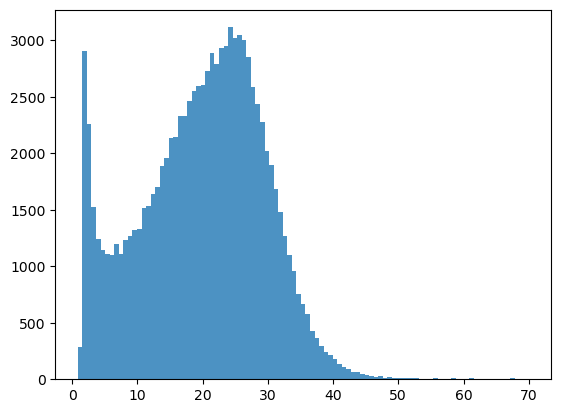

In [5]:
bins = np.linspace(min(predictors_sel['hm']),max(predictors_sel['hm']),100)
plt.hist((predictors_sel['hm']),bins,alpha=0.8);

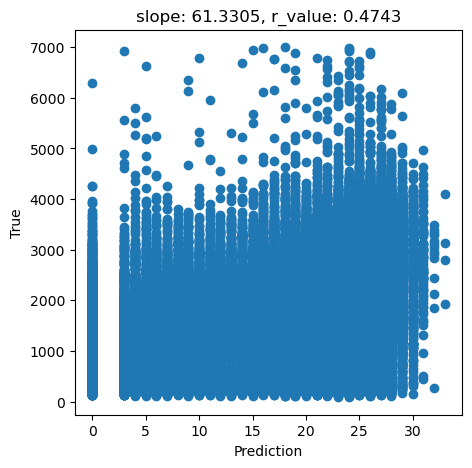

In [6]:
# What we are trying to beat
y_true = predictors_sel['h']
y_pred = predictors_sel['forestheight']

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_true)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(y_pred, y_true)
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
plt.show()


In [7]:
tree_height = predictors_sel['hm'].to_numpy()
data = predictors_sel.drop(columns=['ID','h', 'hm','forestheight'], axis=1)

data.shape[1]: 20, n_plots_x: 5,n_plots_y: 4


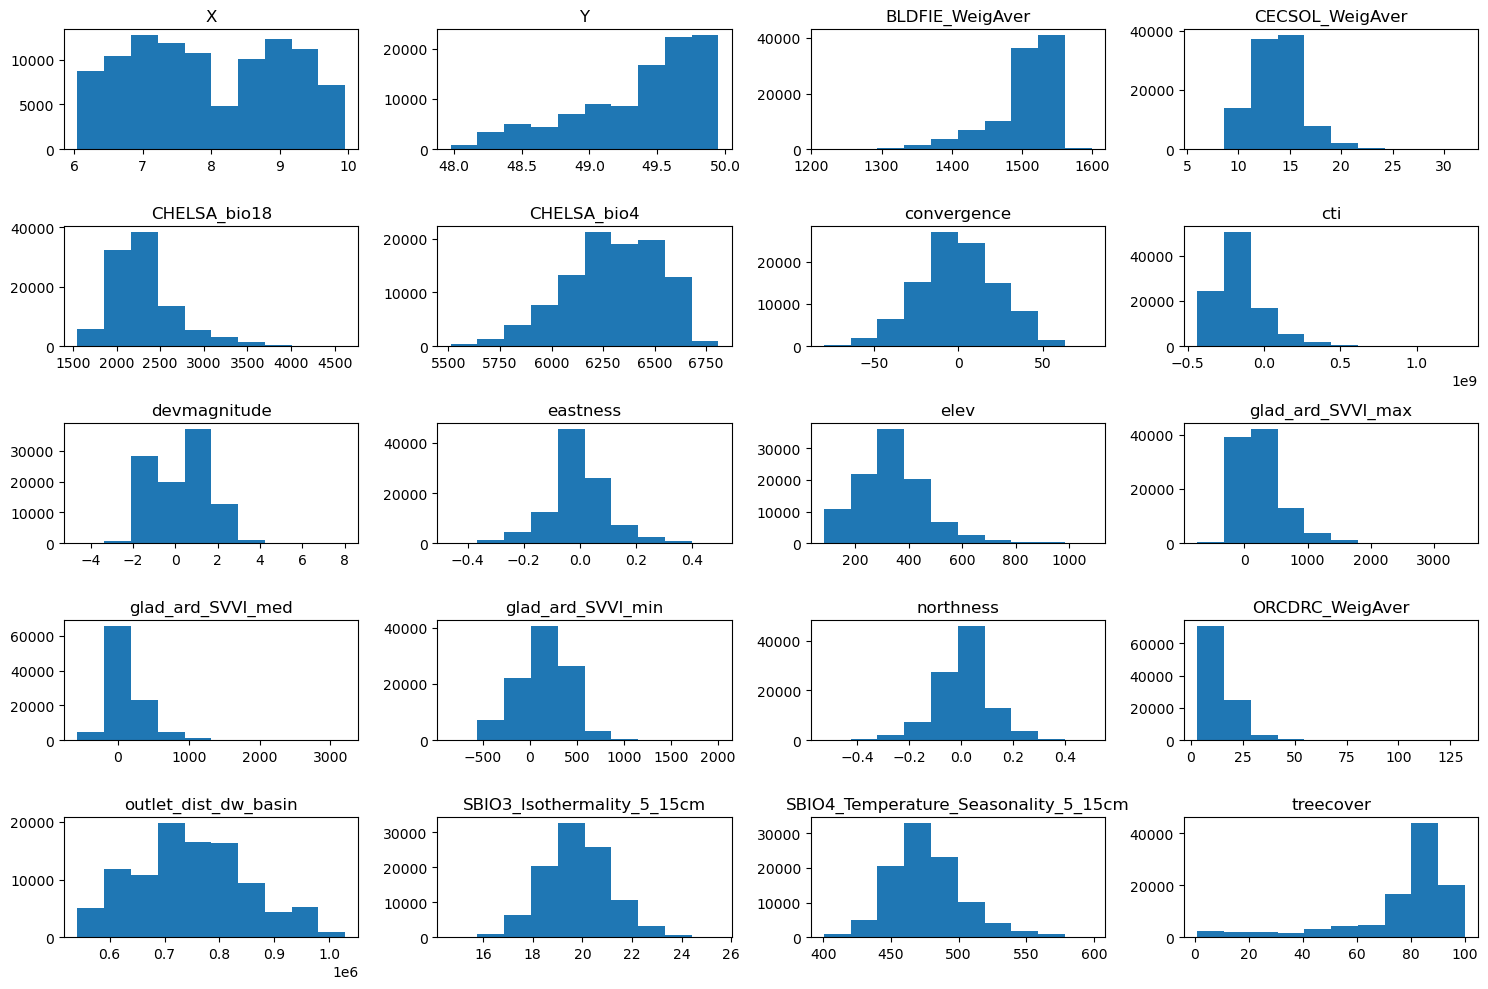

In [8]:
#Explore the raw data
n_plots_x = int(np.ceil(np.sqrt(data.shape[1])))
n_plots_y = int(np.floor(np.sqrt(data.shape[1])))
print('data.shape[1]: {}, n_plots_x: {},n_plots_y: {}'.format(data.shape[1],n_plots_x,n_plots_y))
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(data.shape[1]):
    ax[idx].hist(data.iloc[:, idx].to_numpy().flatten())
    ax[idx].set_title(data.columns[idx])
fig.tight_layout()

Since our target variable is highly skewed, let's use a power transformation to make it more normal-like. Check this [blog](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html#sphx-glr-auto-examples-preprocessing-plot-map-data-to-normal-py) for other commonly used power transformations 

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 1.060e+02, 1.900e+02,
        3.670e+02, 4.730e+02, 7.720e+02, 1.152e+03, 1.490e+03, 2.502e+03,
        3.213e+03, 4.129e+03, 5.043e+03, 6.236e+03, 6.872e+03, 8.668e+03,
        8.159e+03, 8.413e+03, 8.249e+03, 7.757e+03, 6.651e+03, 5.468e+03,
        3.980e+03, 3.010e+03, 2.322e+03, 1.635e+03, 1.269e+03, 8.220e+02,
        4.610e+02, 2.880e+02, 1.350e+02, 9.700e+01, 3.300e+01, 1.200e+01,
        9.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 9.000e+00]),
 array([-2.25692362e+00, -2.16664668e+00, -2.07636973e+00, -1.98609279e+00,
        -1.89581584e+00, -1.80553890e+00, -1.71526195e+00, -1.62498501e+00,
        -1.53470806e+00, -1.44443112e+00, -1.35415417e+00, -1.26387723e+00,
        -1.17360028e+00, -1.08332334e+00, -9.93046394e-01, -9.02769449e-01,
        -8.12492504e-01, -7.22215559e-01, -6.31938615e-01, -5.41661670e-

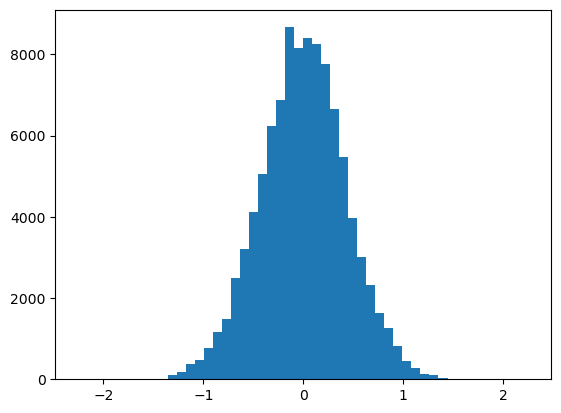

In [9]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
qt = QuantileTransformer(
    n_quantiles=500, output_distribution="normal", random_state=0
)

tree_height = qt.fit_transform(tree_height.reshape(-1,1))
scaler_tree = MinMaxScaler(feature_range=(-1,1))
tree_height = scaler_tree.fit_transform(tree_height).squeeze()
tree_height =tree_height/np.quantile(tree_height,0.99)
plt.hist(tree_height,50)

data.shape[1]: 20, n_plots_x: 5,n_plots_y: 4


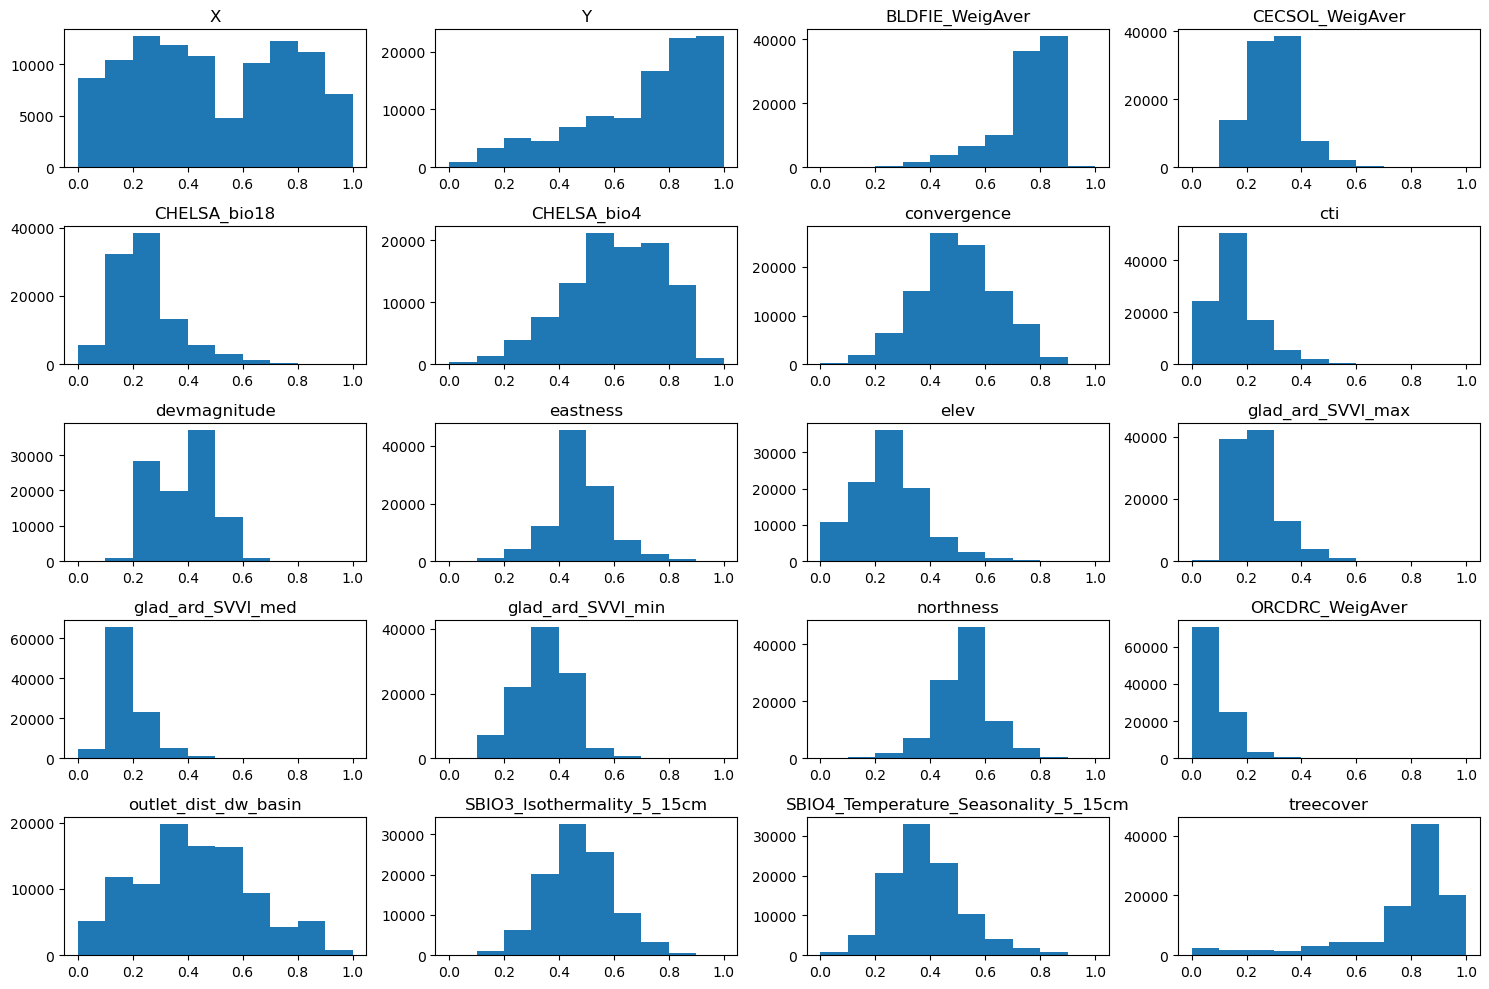

In [10]:
#Normalize the data
scaler_data = MinMaxScaler()
data_transformed = scaler_data.fit_transform(data)

n_plots_x = int(np.ceil(np.sqrt(data.shape[1])))
n_plots_y = int(np.floor(np.sqrt(data.shape[1])))
print('data.shape[1]: {}, n_plots_x: {},n_plots_y: {}'.format(data.shape[1],n_plots_x,n_plots_y))
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(data.shape[1]):
    ax[idx].hist(data_transformed[:,idx].flatten())
    ax[idx].set_title(data.columns[idx])
fig.tight_layout()

In [11]:
# Let's use all the data as one big minibatch

#Split the data
X_train, X_test, y_train, y_test = train_test_split(data_transformed,tree_height, test_size=0.30, random_state=0)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
print('X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print('X_train.min: {}, X_test.min: {}, y_train.min: {}, y_test.min: {}'.format(X_train.min(), X_test.min(), y_train.min(), y_test.min()))
print('X_train.max: {}, X_test.max: {}, y_train.max: {}, y_test.max: {}'.format(X_train.max(), X_test.max(), y_train.max(), y_test.max()))

X_train.shape: torch.Size([70000, 20]), X_test.shape: torch.Size([30000, 20]), y_train.shape: torch.Size([70000]), y_test.shape: torch.Size([30000])
X_train.min: 0.0, X_test.min: 0.0, y_train.min: -2.2569236755371094, y_test.min: -2.2569236755371094
X_train.max: 1.0, X_test.max: 1.0, y_train.max: 2.2569236755371094, y_test.max: 2.2569236755371094


In [12]:
# Try with FF
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        output = self.tanh(self.fc3(hidden))

        return output


hid_dim: 128, lr: 0.75
Epoch 0, train_loss: 0.1980, val_loss: 0.2900, r_value: 0.1720
Epoch 500, train_loss: 0.1546, val_loss: 0.1568, r_value: 0.4467
Epoch 1000, train_loss: 0.1511, val_loss: 0.1527, r_value: 0.4671
Epoch 1500, train_loss: 0.1482, val_loss: 0.1495, r_value: 0.4792
Epoch 2000, train_loss: 0.1463, val_loss: 0.1477, r_value: 0.4872
Epoch 2500, train_loss: 0.1407, val_loss: 0.1433, r_value: 0.4914
Epoch 3000, train_loss: 0.1458, val_loss: 0.1472, r_value: 0.4819
Epoch 3500, train_loss: 0.1445, val_loss: 0.1462, r_value: 0.4892
Epoch 4000, train_loss: 0.1436, val_loss: 0.1454, r_value: 0.4950
Epoch 4500, train_loss: 0.1426, val_loss: 0.1438, r_value: 0.5006
Epoch 5000, train_loss: 0.1389, val_loss: 0.1423, r_value: 0.5012
Epoch 5500, train_loss: 0.1377, val_loss: 0.1394, r_value: 0.5113
Epoch 6000, train_loss: 0.1382, val_loss: 0.1422, r_value: 0.5141
Epoch 6500, train_loss: 0.1336, val_loss: 0.1358, r_value: 0.5133
Epoch 7000, train_loss: 0.1338, val_loss: 0.1368, r_valu

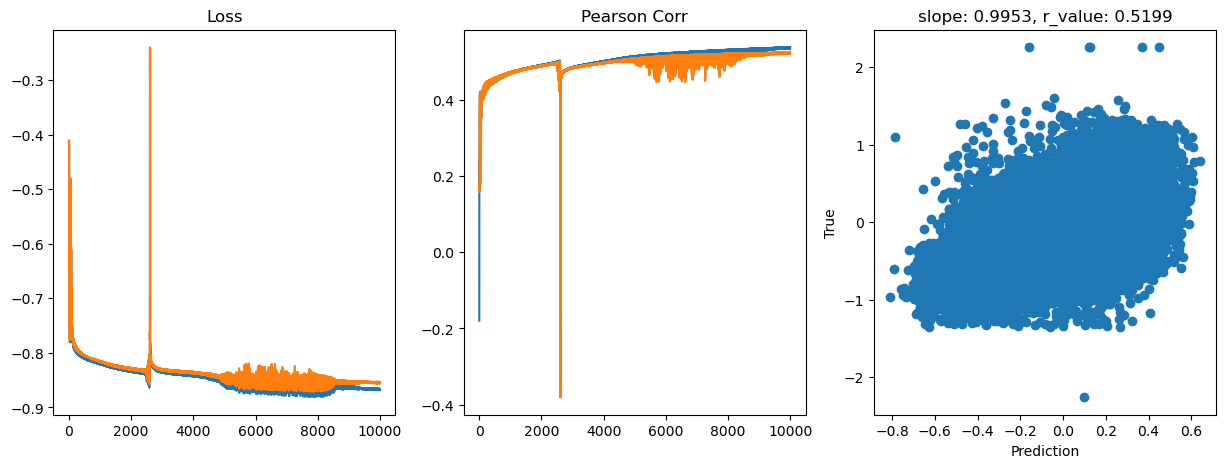


hid_dim: 128, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.1866, val_loss: 0.1999, r_value: 0.3091
Epoch 500, train_loss: 0.1477, val_loss: 0.1487, r_value: 0.4653
Epoch 1000, train_loss: 0.1440, val_loss: 0.1456, r_value: 0.4816
Epoch 1500, train_loss: 0.1419, val_loss: 0.1436, r_value: 0.4917
Epoch 2000, train_loss: 0.1403, val_loss: 0.1421, r_value: 0.4993
Epoch 2500, train_loss: 0.1391, val_loss: 0.1409, r_value: 0.5051
Epoch 3000, train_loss: 0.1377, val_loss: 0.1395, r_value: 0.5096
Epoch 3500, train_loss: 0.1371, val_loss: 0.1390, r_value: 0.5098
Epoch 4000, train_loss: 0.1368, val_loss: 0.1389, r_value: 0.5144
Epoch 4500, train_loss: 0.1380, val_loss: 0.1401, r_value: 0.5093
Epoch 5000, train_loss: 0.1360, val_loss: 0.1386, r_value: 0.5160
Epoch 5500, train_loss: 0.1337, val_loss: 0.1358, r_value: 0.5164
Epoch 6000, train_loss: 0.1358, val_loss: 0.1387, r_value: 0.5192
Epoch 6500, train_loss: 0.1350, val_loss: 0.1380, r_value: 0.5205
Epoch 7000, train_loss: 0.1338, v

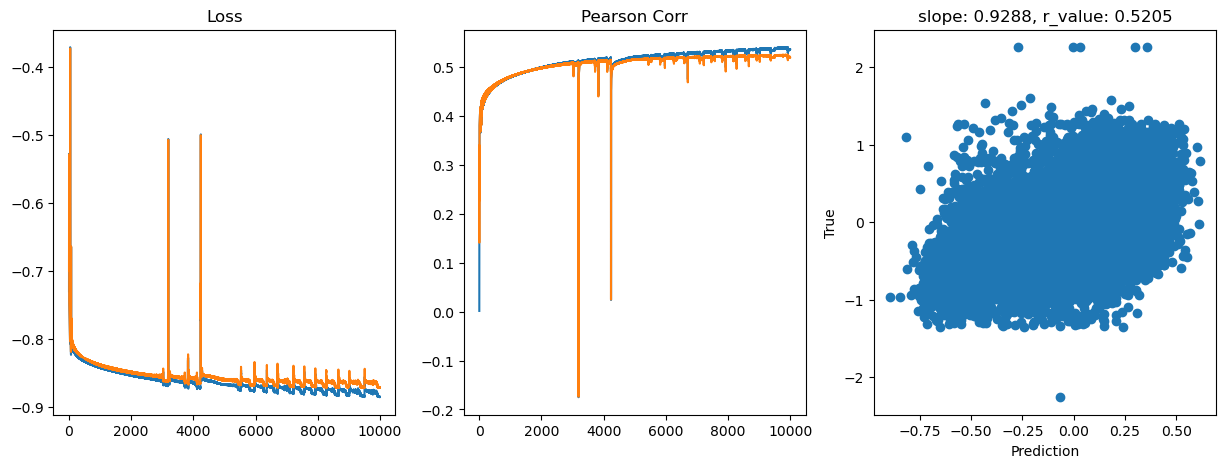


hid_dim: 128, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.1887, val_loss: 0.1855, r_value: 0.0150
Epoch 500, train_loss: 0.1459, val_loss: 0.1473, r_value: 0.4486
Epoch 1000, train_loss: 0.1443, val_loss: 0.1458, r_value: 0.4577
Epoch 1500, train_loss: 0.1433, val_loss: 0.1448, r_value: 0.4634
Epoch 2000, train_loss: 0.1430, val_loss: 0.1444, r_value: 0.4679
Epoch 2500, train_loss: 0.1423, val_loss: 0.1437, r_value: 0.4719
Epoch 3000, train_loss: 0.1417, val_loss: 0.1431, r_value: 0.4754
Epoch 3500, train_loss: 0.1412, val_loss: 0.1426, r_value: 0.4786
Epoch 4000, train_loss: 0.1406, val_loss: 0.1420, r_value: 0.4817
Epoch 4500, train_loss: 0.1401, val_loss: 0.1415, r_value: 0.4845
Epoch 5000, train_loss: 0.1397, val_loss: 0.1411, r_value: 0.4872
Epoch 5500, train_loss: 0.1392, val_loss: 0.1407, r_value: 0.4896
Epoch 6000, train_loss: 0.1388, val_loss: 0.1403, r_value: 0.4920
Epoch 6500, train_loss: 0.1383, val_loss: 0.1399, r_value: 0.4942
Epoch 7000, train_loss: 0.1380, v

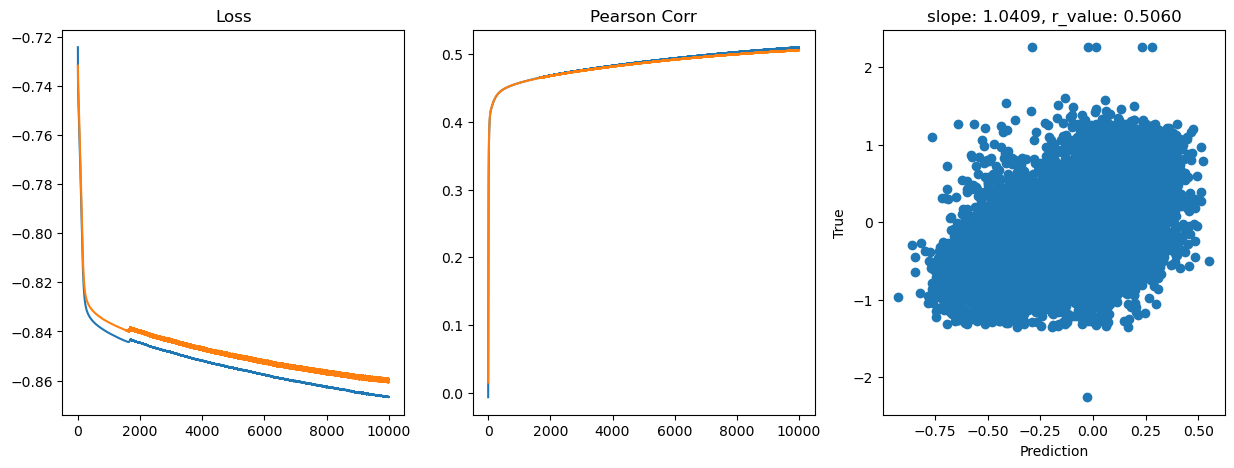


hid_dim: 128, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.1791, val_loss: 0.1808, r_value: 0.3447
Epoch 500, train_loss: 0.1681, val_loss: 0.1699, r_value: 0.3934
Epoch 1000, train_loss: 0.1578, val_loss: 0.1595, r_value: 0.4126
Epoch 1500, train_loss: 0.1514, val_loss: 0.1532, r_value: 0.4245
Epoch 2000, train_loss: 0.1488, val_loss: 0.1505, r_value: 0.4325
Epoch 2500, train_loss: 0.1476, val_loss: 0.1492, r_value: 0.4380
Epoch 3000, train_loss: 0.1469, val_loss: 0.1485, r_value: 0.4418
Epoch 3500, train_loss: 0.1464, val_loss: 0.1480, r_value: 0.4448
Epoch 4000, train_loss: 0.1461, val_loss: 0.1475, r_value: 0.4471
Epoch 4500, train_loss: 0.1457, val_loss: 0.1472, r_value: 0.4491
Epoch 5000, train_loss: 0.1455, val_loss: 0.1469, r_value: 0.4509
Epoch 5500, train_loss: 0.1452, val_loss: 0.1467, r_value: 0.4524
Epoch 6000, train_loss: 0.1450, val_loss: 0.1465, r_value: 0.4537
Epoch 6500, train_loss: 0.1448, val_loss: 0.1463, r_value: 0.4548
Epoch 7000, train_loss: 0.1447, 

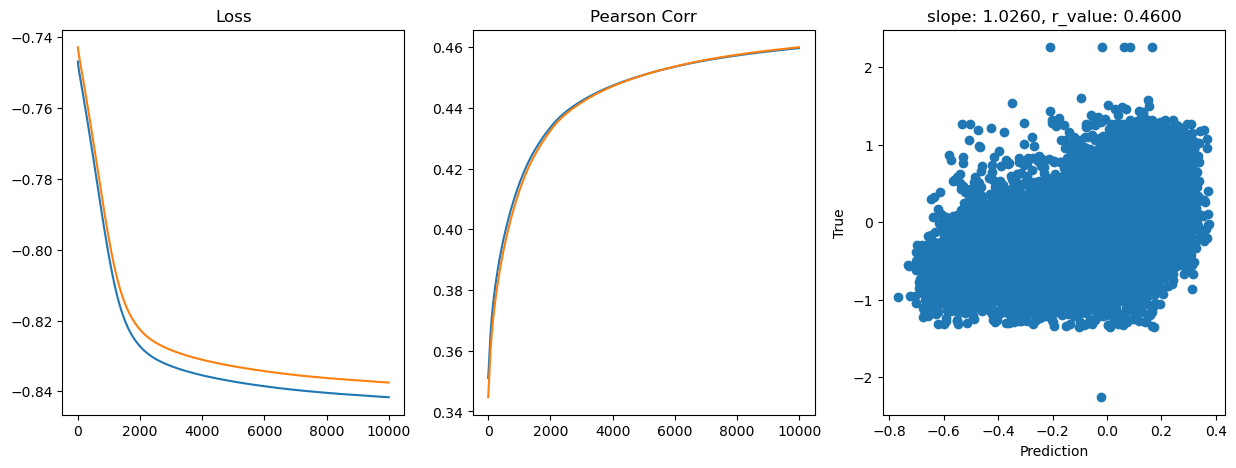


hid_dim: 128, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.1842, val_loss: 0.1845, r_value: 0.0583
Epoch 500, train_loss: 0.1472, val_loss: 0.1486, r_value: 0.4409
Epoch 1000, train_loss: 0.1458, val_loss: 0.1472, r_value: 0.4490
Epoch 1500, train_loss: 0.1451, val_loss: 0.1465, r_value: 0.4534
Epoch 2000, train_loss: 0.1445, val_loss: 0.1459, r_value: 0.4567
Epoch 2500, train_loss: 0.1441, val_loss: 0.1455, r_value: 0.4592
Epoch 3000, train_loss: 0.1437, val_loss: 0.1451, r_value: 0.4614
Epoch 3500, train_loss: 0.1433, val_loss: 0.1448, r_value: 0.4634
Epoch 4000, train_loss: 0.1430, val_loss: 0.1444, r_value: 0.4654
Epoch 4500, train_loss: 0.1427, val_loss: 0.1441, r_value: 0.4676
Epoch 5000, train_loss: 0.1423, val_loss: 0.1437, r_value: 0.4696
Epoch 5500, train_loss: 0.1420, val_loss: 0.1434, r_value: 0.4716
Epoch 6000, train_loss: 0.1416, val_loss: 0.1430, r_value: 0.4737
Epoch 6500, train_loss: 0.1413, val_loss: 0.1427, r_value: 0.4757
Epoch 7000, train_loss: 0.1409, 

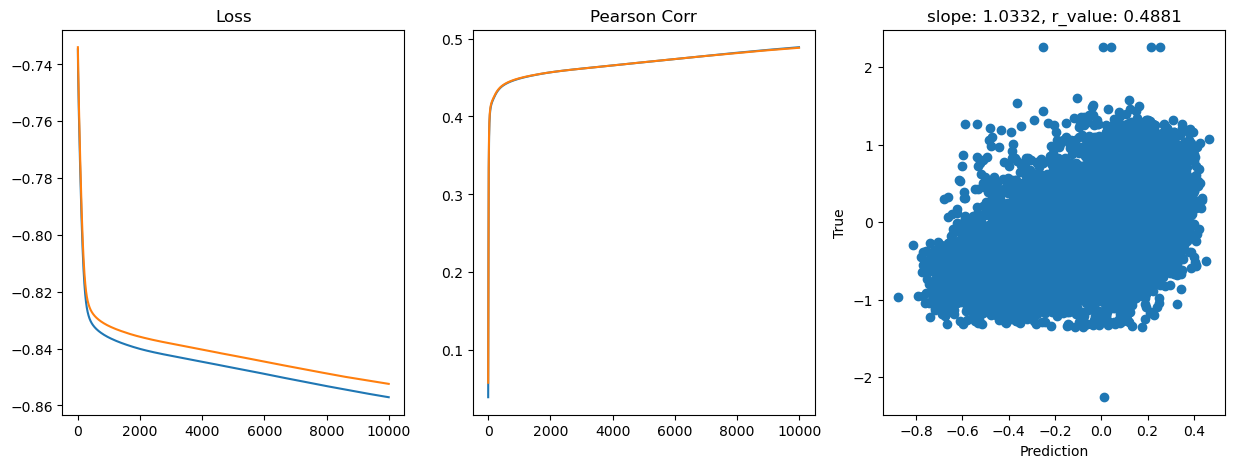


hid_dim: 256, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.1870, val_loss: 0.2367, r_value: 0.0894
Epoch 500, train_loss: 0.1555, val_loss: 0.1558, r_value: 0.4674
Epoch 1000, train_loss: 0.1504, val_loss: 0.1517, r_value: 0.4843
Epoch 1500, train_loss: 0.1471, val_loss: 0.1489, r_value: 0.4943
Epoch 2000, train_loss: 0.1444, val_loss: 0.1456, r_value: 0.5017
Epoch 2500, train_loss: 0.1436, val_loss: 0.1441, r_value: 0.5048
Epoch 3000, train_loss: 0.1441, val_loss: 0.1448, r_value: 0.5066
Epoch 3500, train_loss: 0.1403, val_loss: 0.1427, r_value: 0.5131
Epoch 4000, train_loss: 0.1394, val_loss: 0.1422, r_value: 0.5156
Epoch 4500, train_loss: 0.1385, val_loss: 0.1416, r_value: 0.5178
Epoch 5000, train_loss: 0.1377, val_loss: 0.1411, r_value: 0.5197
Epoch 5500, train_loss: 0.1371, val_loss: 0.1407, r_value: 0.5214
Epoch 6000, train_loss: 0.1365, val_loss: 0.1404, r_value: 0.5229
Epoch 6500, train_loss: 0.1361, val_loss: 0.1402, r_value: 0.5241
Epoch 7000, train_loss: 0.1356, 

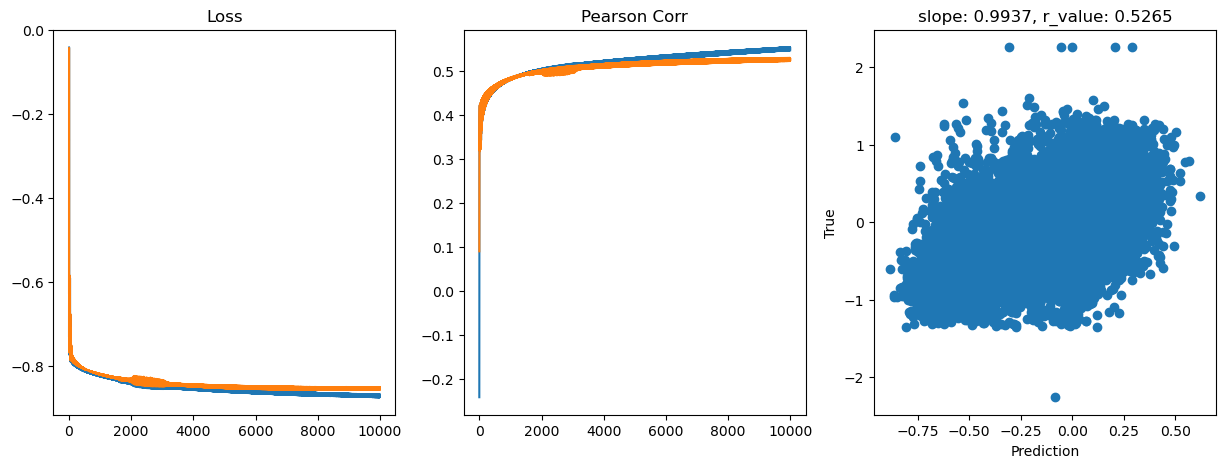


hid_dim: 256, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.1936, val_loss: 0.3296, r_value: 0.2721
Epoch 500, train_loss: 0.1466, val_loss: 0.1482, r_value: 0.4627
Epoch 1000, train_loss: 0.1427, val_loss: 0.1440, r_value: 0.4830
Epoch 1500, train_loss: 0.1407, val_loss: 0.1422, r_value: 0.4936
Epoch 2000, train_loss: 0.1393, val_loss: 0.1410, r_value: 0.5011
Epoch 2500, train_loss: 0.1380, val_loss: 0.1399, r_value: 0.5062
Epoch 3000, train_loss: 0.1369, val_loss: 0.1392, r_value: 0.5100
Epoch 3500, train_loss: 0.1348, val_loss: 0.1377, r_value: 0.5107
Epoch 4000, train_loss: 0.1340, val_loss: 0.1358, r_value: 0.5176
Epoch 4500, train_loss: 0.1344, val_loss: 0.1375, r_value: 0.5164
Epoch 5000, train_loss: 0.1360, val_loss: 0.1410, r_value: 0.5194
Epoch 5500, train_loss: 0.1333, val_loss: 0.1354, r_value: 0.5185
Epoch 6000, train_loss: 0.1341, val_loss: 0.1375, r_value: 0.5242
Epoch 6500, train_loss: 0.1342, val_loss: 0.1379, r_value: 0.5253
Epoch 7000, train_loss: 0.1312, v

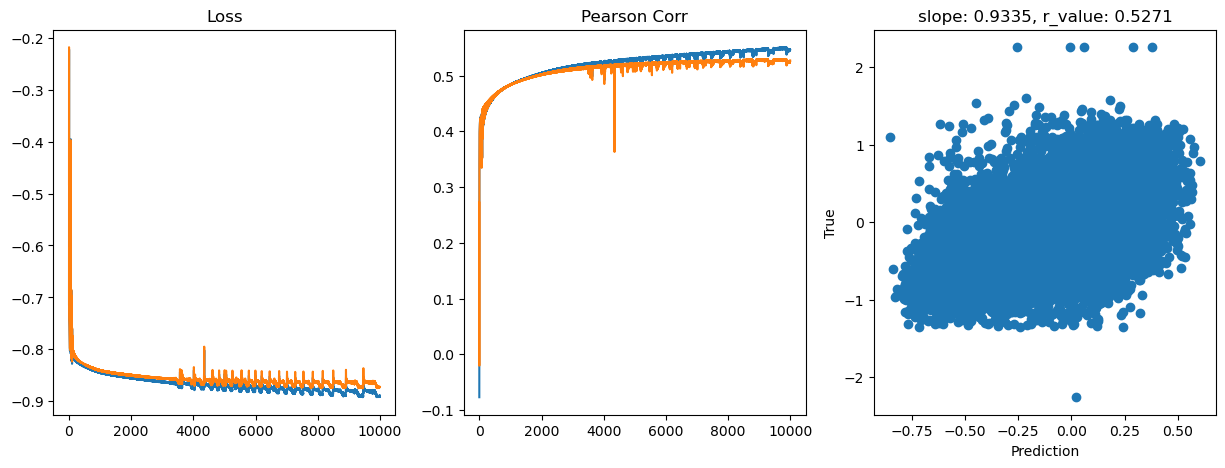


hid_dim: 256, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.1813, val_loss: 0.1823, r_value: 0.1569
Epoch 500, train_loss: 0.1457, val_loss: 0.1469, r_value: 0.4549
Epoch 1000, train_loss: 0.1439, val_loss: 0.1452, r_value: 0.4630
Epoch 1500, train_loss: 0.1429, val_loss: 0.1442, r_value: 0.4684
Epoch 2000, train_loss: 0.1421, val_loss: 0.1434, r_value: 0.4733
Epoch 2500, train_loss: 0.1412, val_loss: 0.1425, r_value: 0.4780
Epoch 3000, train_loss: 0.1405, val_loss: 0.1419, r_value: 0.4824
Epoch 3500, train_loss: 0.1399, val_loss: 0.1413, r_value: 0.4863
Epoch 4000, train_loss: 0.1393, val_loss: 0.1407, r_value: 0.4898
Epoch 4500, train_loss: 0.1386, val_loss: 0.1401, r_value: 0.4931
Epoch 5000, train_loss: 0.1381, val_loss: 0.1396, r_value: 0.4960
Epoch 5500, train_loss: 0.1376, val_loss: 0.1391, r_value: 0.4986
Epoch 6000, train_loss: 0.1371, val_loss: 0.1387, r_value: 0.5009
Epoch 6500, train_loss: 0.1366, val_loss: 0.1383, r_value: 0.5031
Epoch 7000, train_loss: 0.1361, v

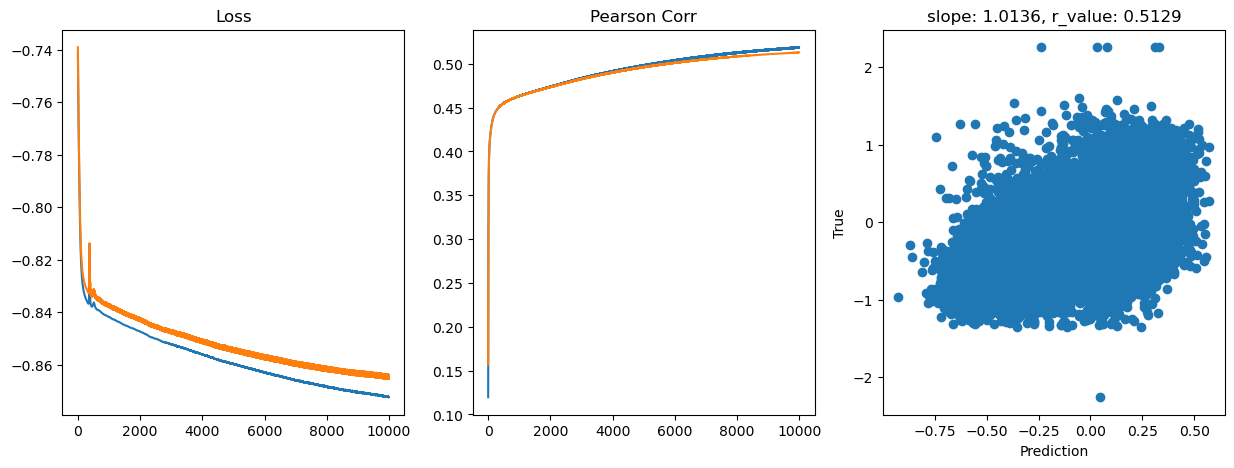


hid_dim: 256, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.1809, val_loss: 0.1824, r_value: 0.2568
Epoch 500, train_loss: 0.1574, val_loss: 0.1590, r_value: 0.4312
Epoch 1000, train_loss: 0.1492, val_loss: 0.1507, r_value: 0.4361
Epoch 1500, train_loss: 0.1473, val_loss: 0.1487, r_value: 0.4412
Epoch 2000, train_loss: 0.1465, val_loss: 0.1480, r_value: 0.4450
Epoch 2500, train_loss: 0.1460, val_loss: 0.1475, r_value: 0.4476
Epoch 3000, train_loss: 0.1457, val_loss: 0.1471, r_value: 0.4498
Epoch 3500, train_loss: 0.1454, val_loss: 0.1468, r_value: 0.4518
Epoch 4000, train_loss: 0.1451, val_loss: 0.1465, r_value: 0.4536
Epoch 4500, train_loss: 0.1448, val_loss: 0.1462, r_value: 0.4551
Epoch 5000, train_loss: 0.1446, val_loss: 0.1460, r_value: 0.4564
Epoch 5500, train_loss: 0.1444, val_loss: 0.1458, r_value: 0.4576
Epoch 6000, train_loss: 0.1442, val_loss: 0.1456, r_value: 0.4587
Epoch 6500, train_loss: 0.1440, val_loss: 0.1454, r_value: 0.4598
Epoch 7000, train_loss: 0.1439, 

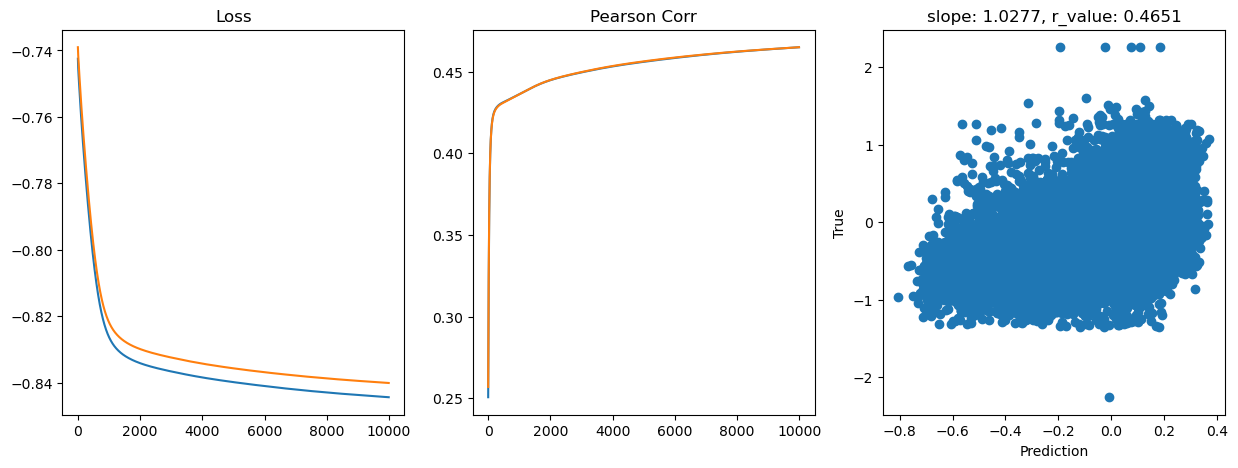


hid_dim: 256, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.1823, val_loss: 0.1836, r_value: 0.1037
Epoch 500, train_loss: 0.1465, val_loss: 0.1480, r_value: 0.4446
Epoch 1000, train_loss: 0.1450, val_loss: 0.1465, r_value: 0.4536
Epoch 1500, train_loss: 0.1441, val_loss: 0.1456, r_value: 0.4588
Epoch 2000, train_loss: 0.1435, val_loss: 0.1449, r_value: 0.4626
Epoch 2500, train_loss: 0.1429, val_loss: 0.1444, r_value: 0.4659
Epoch 3000, train_loss: 0.1424, val_loss: 0.1439, r_value: 0.4689
Epoch 3500, train_loss: 0.1419, val_loss: 0.1434, r_value: 0.4717
Epoch 4000, train_loss: 0.1414, val_loss: 0.1429, r_value: 0.4743
Epoch 4500, train_loss: 0.1410, val_loss: 0.1425, r_value: 0.4768
Epoch 5000, train_loss: 0.1406, val_loss: 0.1421, r_value: 0.4791
Epoch 5500, train_loss: 0.1402, val_loss: 0.1417, r_value: 0.4814
Epoch 6000, train_loss: 0.1398, val_loss: 0.1413, r_value: 0.4834
Epoch 6500, train_loss: 0.1394, val_loss: 0.1410, r_value: 0.4854
Epoch 7000, train_loss: 0.1390, 

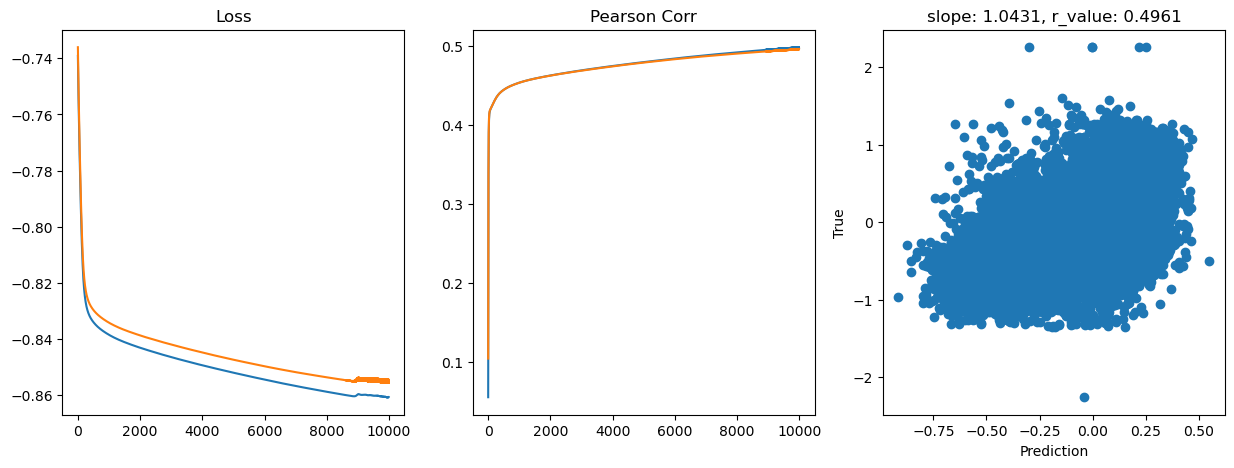


hid_dim: 512, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.1908, val_loss: 0.6607, r_value: 0.0161
Epoch 500, train_loss: 0.1560, val_loss: 0.1566, r_value: 0.4662
Epoch 1000, train_loss: 0.1496, val_loss: 0.1512, r_value: 0.4841
Epoch 1500, train_loss: 0.1467, val_loss: 0.1486, r_value: 0.4953
Epoch 2000, train_loss: 0.1444, val_loss: 0.1468, r_value: 0.4998
Epoch 2500, train_loss: 0.1431, val_loss: 0.1453, r_value: 0.5035
Epoch 3000, train_loss: 0.1420, val_loss: 0.1442, r_value: 0.5070
Epoch 3500, train_loss: 0.1410, val_loss: 0.1433, r_value: 0.5102
Epoch 4000, train_loss: 0.1402, val_loss: 0.1427, r_value: 0.5128
Epoch 4500, train_loss: 0.1395, val_loss: 0.1422, r_value: 0.5151
Epoch 5000, train_loss: 0.1389, val_loss: 0.1419, r_value: 0.5172
Epoch 5500, train_loss: 0.1383, val_loss: 0.1416, r_value: 0.5189
Epoch 6000, train_loss: 0.1378, val_loss: 0.1415, r_value: 0.5204
Epoch 6500, train_loss: 0.1373, val_loss: 0.1413, r_value: 0.5220
Epoch 7000, train_loss: 0.1368, 

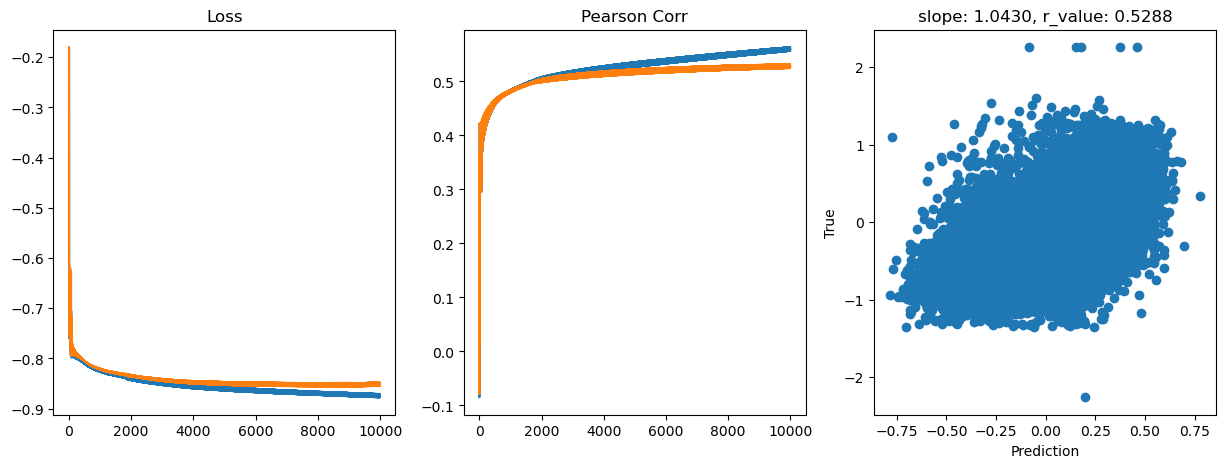


hid_dim: 512, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.1871, val_loss: 0.3020, r_value: 0.2117
Epoch 500, train_loss: 0.1485, val_loss: 0.1495, r_value: 0.4665
Epoch 1000, train_loss: 0.1436, val_loss: 0.1453, r_value: 0.4839
Epoch 1500, train_loss: 0.1409, val_loss: 0.1429, r_value: 0.4947
Epoch 2000, train_loss: 0.1392, val_loss: 0.1414, r_value: 0.5034
Epoch 2500, train_loss: 0.1379, val_loss: 0.1402, r_value: 0.5100
Epoch 3000, train_loss: 0.1368, val_loss: 0.1394, r_value: 0.5144
Epoch 3500, train_loss: 0.1359, val_loss: 0.1387, r_value: 0.5176
Epoch 4000, train_loss: 0.1353, val_loss: 0.1384, r_value: 0.5199
Epoch 4500, train_loss: 0.1343, val_loss: 0.1377, r_value: 0.5220
Epoch 5000, train_loss: 0.1340, val_loss: 0.1377, r_value: 0.5236
Epoch 5500, train_loss: 0.1338, val_loss: 0.1382, r_value: 0.5249
Epoch 6000, train_loss: 0.1330, val_loss: 0.1375, r_value: 0.5262
Epoch 6500, train_loss: 0.1318, val_loss: 0.1363, r_value: 0.5274
Epoch 7000, train_loss: 0.1324, v

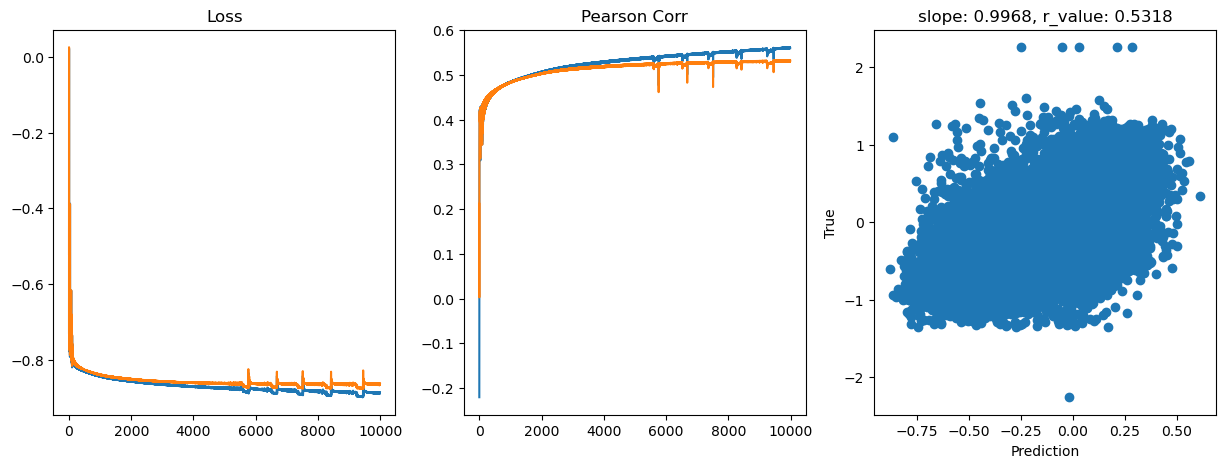


hid_dim: 512, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.1875, val_loss: 0.1850, r_value: 0.2663
Epoch 500, train_loss: 0.1452, val_loss: 0.1465, r_value: 0.4566
Epoch 1000, train_loss: 0.1435, val_loss: 0.1448, r_value: 0.4658
Epoch 1500, train_loss: 0.1424, val_loss: 0.1436, r_value: 0.4730
Epoch 2000, train_loss: 0.1414, val_loss: 0.1427, r_value: 0.4791
Epoch 2500, train_loss: 0.1405, val_loss: 0.1418, r_value: 0.4842
Epoch 3000, train_loss: 0.1397, val_loss: 0.1411, r_value: 0.4886
Epoch 3500, train_loss: 0.1390, val_loss: 0.1405, r_value: 0.4925
Epoch 4000, train_loss: 0.1383, val_loss: 0.1399, r_value: 0.4960
Epoch 4500, train_loss: 0.1377, val_loss: 0.1393, r_value: 0.4992
Epoch 5000, train_loss: 0.1371, val_loss: 0.1388, r_value: 0.5020
Epoch 5500, train_loss: 0.1365, val_loss: 0.1383, r_value: 0.5046
Epoch 6000, train_loss: 0.1359, val_loss: 0.1379, r_value: 0.5068
Epoch 6500, train_loss: 0.1355, val_loss: 0.1374, r_value: 0.5088
Epoch 7000, train_loss: 0.1350, v

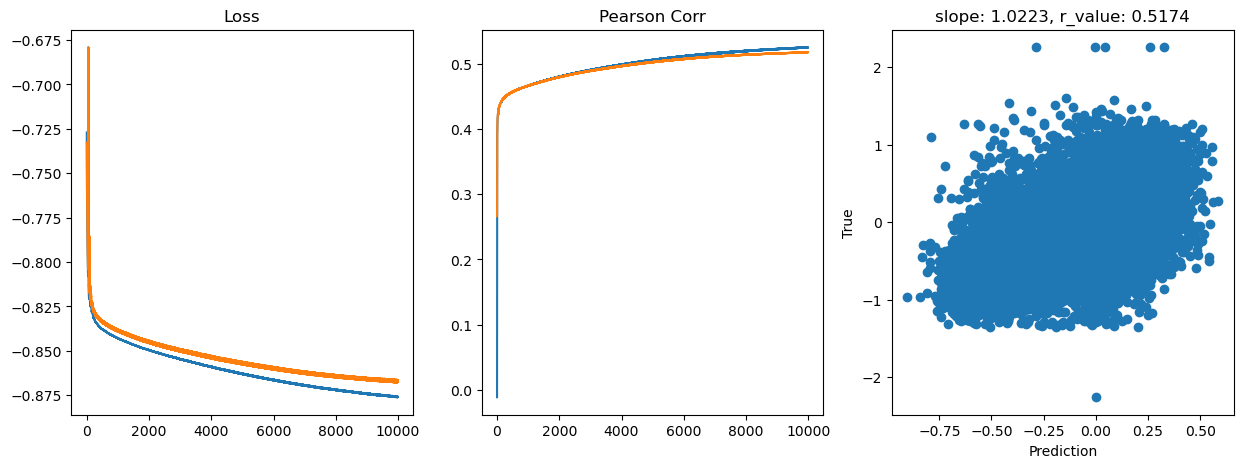


hid_dim: 512, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.1902, val_loss: 0.1894, r_value: 0.0326
Epoch 500, train_loss: 0.1530, val_loss: 0.1546, r_value: 0.4256
Epoch 1000, train_loss: 0.1480, val_loss: 0.1496, r_value: 0.4372
Epoch 1500, train_loss: 0.1466, val_loss: 0.1481, r_value: 0.4441
Epoch 2000, train_loss: 0.1458, val_loss: 0.1473, r_value: 0.4485
Epoch 2500, train_loss: 0.1453, val_loss: 0.1468, r_value: 0.4517
Epoch 3000, train_loss: 0.1449, val_loss: 0.1464, r_value: 0.4541
Epoch 3500, train_loss: 0.1446, val_loss: 0.1461, r_value: 0.4559
Epoch 4000, train_loss: 0.1443, val_loss: 0.1458, r_value: 0.4574
Epoch 4500, train_loss: 0.1441, val_loss: 0.1456, r_value: 0.4587
Epoch 5000, train_loss: 0.1439, val_loss: 0.1454, r_value: 0.4598
Epoch 5500, train_loss: 0.1438, val_loss: 0.1453, r_value: 0.4607
Epoch 6000, train_loss: 0.1436, val_loss: 0.1451, r_value: 0.4616
Epoch 6500, train_loss: 0.1435, val_loss: 0.1450, r_value: 0.4625
Epoch 7000, train_loss: 0.1433, 

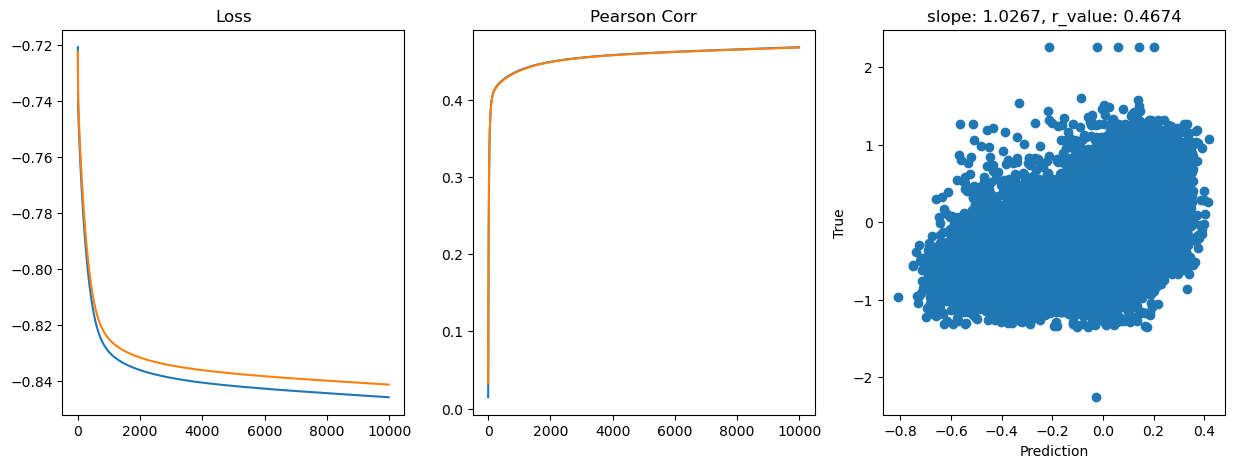


hid_dim: 512, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.1858, val_loss: 0.1832, r_value: 0.1049
Epoch 500, train_loss: 0.1454, val_loss: 0.1469, r_value: 0.4513
Epoch 1000, train_loss: 0.1441, val_loss: 0.1456, r_value: 0.4589
Epoch 1500, train_loss: 0.1434, val_loss: 0.1449, r_value: 0.4627
Epoch 2000, train_loss: 0.1429, val_loss: 0.1444, r_value: 0.4658
Epoch 2500, train_loss: 0.1430, val_loss: 0.1447, r_value: 0.4687
Epoch 3000, train_loss: 0.1425, val_loss: 0.1442, r_value: 0.4715
Epoch 3500, train_loss: 0.1420, val_loss: 0.1437, r_value: 0.4741
Epoch 4000, train_loss: 0.1416, val_loss: 0.1433, r_value: 0.4766
Epoch 4500, train_loss: 0.1412, val_loss: 0.1429, r_value: 0.4791
Epoch 5000, train_loss: 0.1407, val_loss: 0.1425, r_value: 0.4815
Epoch 5500, train_loss: 0.1403, val_loss: 0.1421, r_value: 0.4838
Epoch 6000, train_loss: 0.1399, val_loss: 0.1418, r_value: 0.4859
Epoch 6500, train_loss: 0.1395, val_loss: 0.1414, r_value: 0.4880
Epoch 7000, train_loss: 0.1392, 

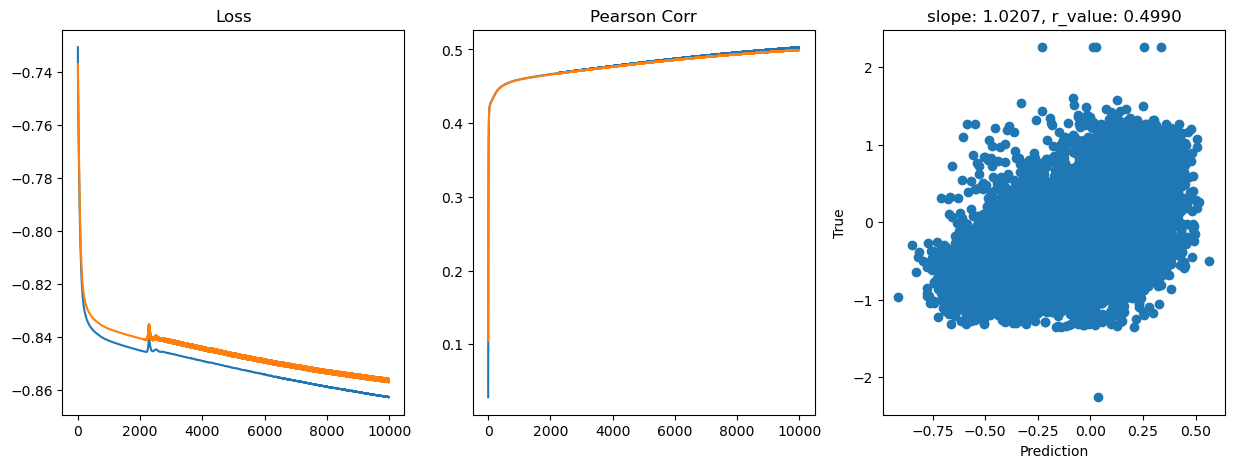

In [13]:
# model.train()
epoch = 10000
hid_dim_range = [128,256,512]
lr_range = [0.75,0.5,0.1,0.01,0.05]

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Feedforward(data.shape[1], hid_dim).to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        all_r_train=[]
        all_r_val=[]
        
        for epoch in range(epoch):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train.to(device))
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train.to(device))

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())
            y_pred = y_pred.cpu().detach().numpy().squeeze()
            _, _, r_value_train, _, _ = scipy.stats.linregress(y_pred, y_train)
            all_r_train.append(r_value_train)

            model.eval()
            with torch.no_grad():
                y_pred = model(X_test.to(device))
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test.to(device))
                all_loss_val.append(loss.item())
                
                y_pred = y_pred.cpu().detach().numpy().squeeze()
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                all_r_val.append(r_value)
                # r_value2 = pearsonr(y_pred, y_test)[0]
            
                if epoch%500==0:
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,3,figsize=(15,5))
        ax[0].plot(np.log10(all_loss_train))
        ax[0].plot(np.log10(all_loss_val))
        ax[0].set_title('Loss')
        
        ax[1].plot(all_r_train)
        ax[1].plot(all_r_val)
        ax[1].set_title('Pearson Corr')

        ax[2].scatter(y_pred, y_test.cpu())
        ax[2].set_xlabel('Prediction')
        ax[2].set_ylabel('True')
        ax[2].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()

In [14]:
# Try deeper FF
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc4 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        hidden = self.relu(self.fc3(hidden))
        hidden = self.relu(self.fc4(hidden))
        output = self.tanh(self.fc5(hidden))

        return output


hid_dim: 128, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.1823, val_loss: 0.1838, r_value: 0.1924
Epoch 500, train_loss: 0.1588, val_loss: 0.1564, r_value: 0.4524
Epoch 1000, train_loss: 0.1560, val_loss: 0.1555, r_value: 0.4598
Epoch 1500, train_loss: 0.1536, val_loss: 0.1543, r_value: 0.4662
Epoch 2000, train_loss: 0.1520, val_loss: 0.1534, r_value: 0.4733
Epoch 2500, train_loss: 0.1498, val_loss: 0.1517, r_value: 0.4793
Epoch 3000, train_loss: 0.1482, val_loss: 0.1502, r_value: 0.4841
Epoch 3500, train_loss: 0.1476, val_loss: 0.1488, r_value: 0.4887
Epoch 4000, train_loss: 0.1470, val_loss: 0.1470, r_value: 0.4950
Epoch 4500, train_loss: 0.1510, val_loss: 0.1525, r_value: 0.4764
Epoch 5000, train_loss: 0.1450, val_loss: 0.1477, r_value: 0.4957
Epoch 5500, train_loss: 0.1444, val_loss: 0.1428, r_value: 0.5038
Epoch 6000, train_loss: 0.1442, val_loss: 0.1469, r_value: 0.5053
Epoch 6500, train_loss: 0.1384, val_loss: 0.1416, r_value: 0.5059
Epoch 7000, train_loss: 0.1424, 

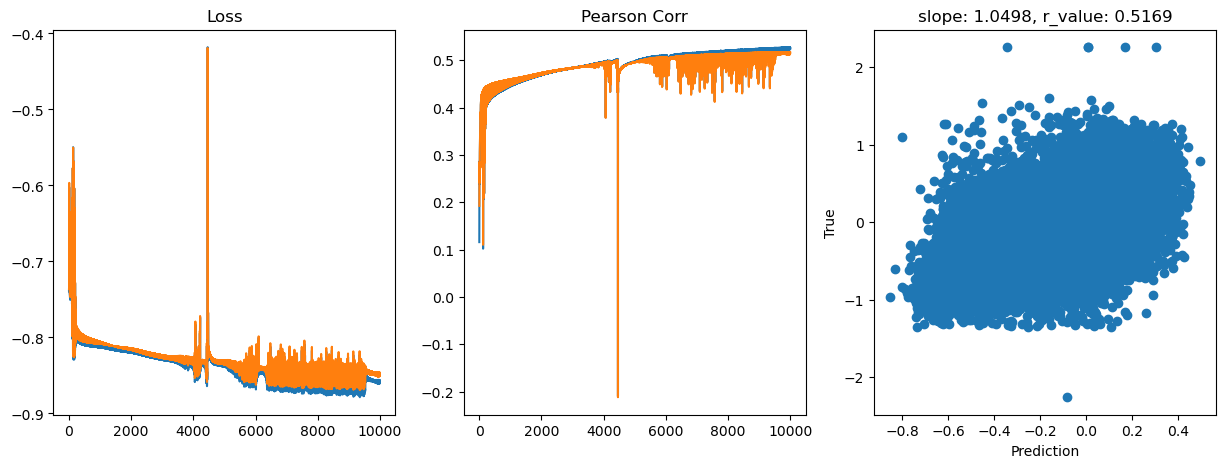


hid_dim: 128, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.1824, val_loss: 0.1840, r_value: 0.2352
Epoch 500, train_loss: 0.1489, val_loss: 0.1511, r_value: 0.4465
Epoch 1000, train_loss: 0.1466, val_loss: 0.1482, r_value: 0.4627
Epoch 1500, train_loss: 0.1450, val_loss: 0.1463, r_value: 0.4735
Epoch 2000, train_loss: 0.1434, val_loss: 0.1446, r_value: 0.4804
Epoch 2500, train_loss: 0.1425, val_loss: 0.1436, r_value: 0.4854
Epoch 3000, train_loss: 0.1425, val_loss: 0.1429, r_value: 0.4906
Epoch 3500, train_loss: 0.1412, val_loss: 0.1422, r_value: 0.4945
Epoch 4000, train_loss: 0.1405, val_loss: 0.1433, r_value: 0.5006
Epoch 4500, train_loss: 0.1381, val_loss: 0.1422, r_value: 0.5001
Epoch 5000, train_loss: 0.1386, val_loss: 0.1399, r_value: 0.5054
Epoch 5500, train_loss: 0.1363, val_loss: 0.1379, r_value: 0.5029
Epoch 6000, train_loss: 0.1365, val_loss: 0.1391, r_value: 0.5123
Epoch 6500, train_loss: 0.1362, val_loss: 0.1385, r_value: 0.5140
Epoch 7000, train_loss: 0.1363, v

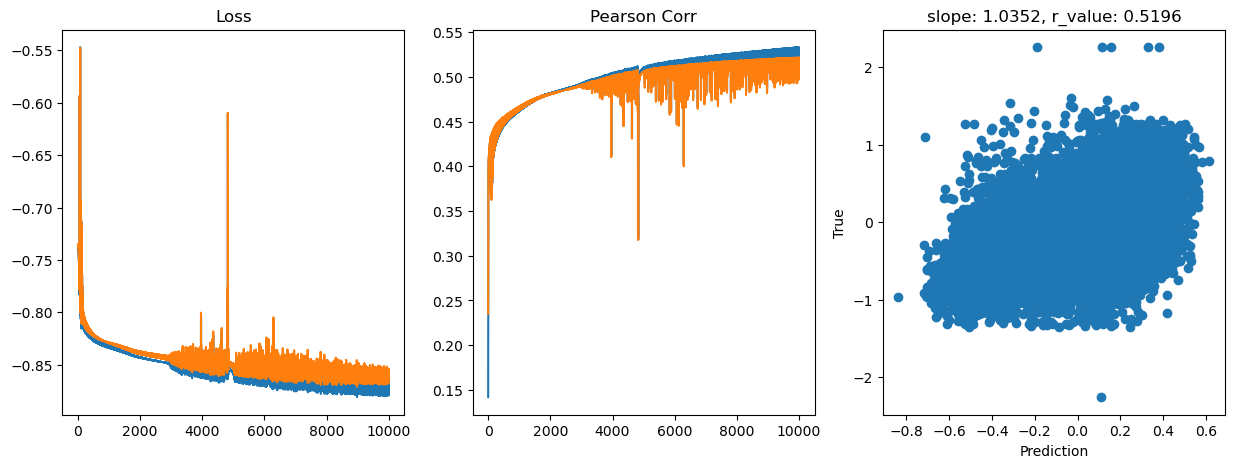


hid_dim: 128, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.1972, val_loss: 0.1922, r_value: -0.0228
Epoch 500, train_loss: 0.1475, val_loss: 0.1487, r_value: 0.4403
Epoch 1000, train_loss: 0.1456, val_loss: 0.1468, r_value: 0.4565
Epoch 1500, train_loss: 0.1445, val_loss: 0.1457, r_value: 0.4629
Epoch 2000, train_loss: 0.1436, val_loss: 0.1448, r_value: 0.4672
Epoch 2500, train_loss: 0.1430, val_loss: 0.1442, r_value: 0.4711
Epoch 3000, train_loss: 0.1424, val_loss: 0.1436, r_value: 0.4747
Epoch 3500, train_loss: 0.1418, val_loss: 0.1430, r_value: 0.4781
Epoch 4000, train_loss: 0.1412, val_loss: 0.1425, r_value: 0.4814
Epoch 4500, train_loss: 0.1407, val_loss: 0.1420, r_value: 0.4845
Epoch 5000, train_loss: 0.1402, val_loss: 0.1415, r_value: 0.4874
Epoch 5500, train_loss: 0.1396, val_loss: 0.1410, r_value: 0.4901
Epoch 6000, train_loss: 0.1391, val_loss: 0.1405, r_value: 0.4926
Epoch 6500, train_loss: 0.1387, val_loss: 0.1402, r_value: 0.4949
Epoch 7000, train_loss: 0.1383, 

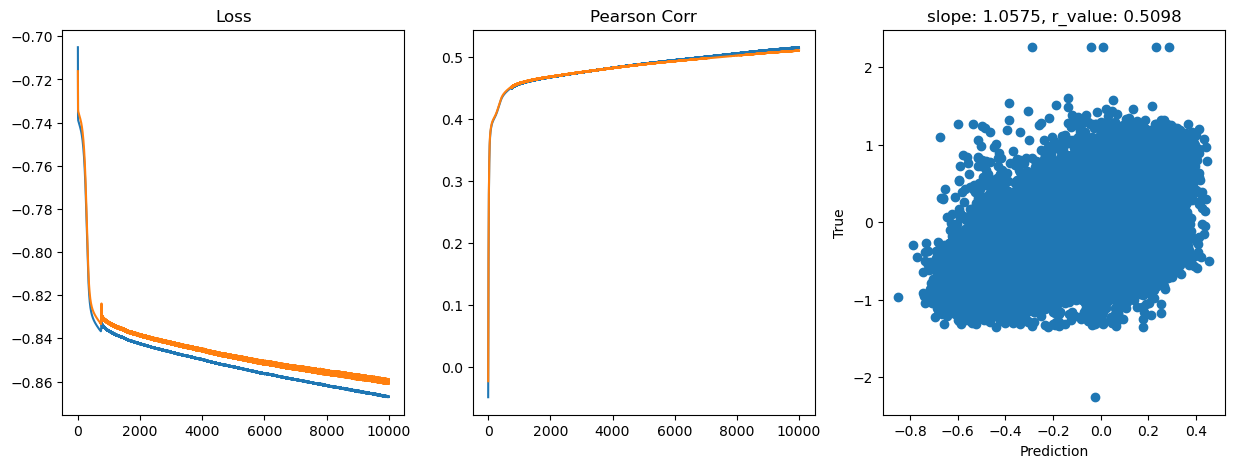


hid_dim: 128, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.1834, val_loss: 0.1853, r_value: -0.2359
Epoch 500, train_loss: 0.1816, val_loss: 0.1834, r_value: 0.3388
Epoch 1000, train_loss: 0.1804, val_loss: 0.1822, r_value: 0.3865
Epoch 1500, train_loss: 0.1786, val_loss: 0.1804, r_value: 0.4007
Epoch 2000, train_loss: 0.1755, val_loss: 0.1772, r_value: 0.4089
Epoch 2500, train_loss: 0.1692, val_loss: 0.1710, r_value: 0.4173
Epoch 3000, train_loss: 0.1597, val_loss: 0.1614, r_value: 0.4241
Epoch 3500, train_loss: 0.1513, val_loss: 0.1530, r_value: 0.4315
Epoch 4000, train_loss: 0.1479, val_loss: 0.1495, r_value: 0.4389
Epoch 4500, train_loss: 0.1467, val_loss: 0.1482, r_value: 0.4441
Epoch 5000, train_loss: 0.1461, val_loss: 0.1475, r_value: 0.4475
Epoch 5500, train_loss: 0.1457, val_loss: 0.1471, r_value: 0.4498
Epoch 6000, train_loss: 0.1454, val_loss: 0.1468, r_value: 0.4516
Epoch 6500, train_loss: 0.1452, val_loss: 0.1465, r_value: 0.4530
Epoch 7000, train_loss: 0.1450,

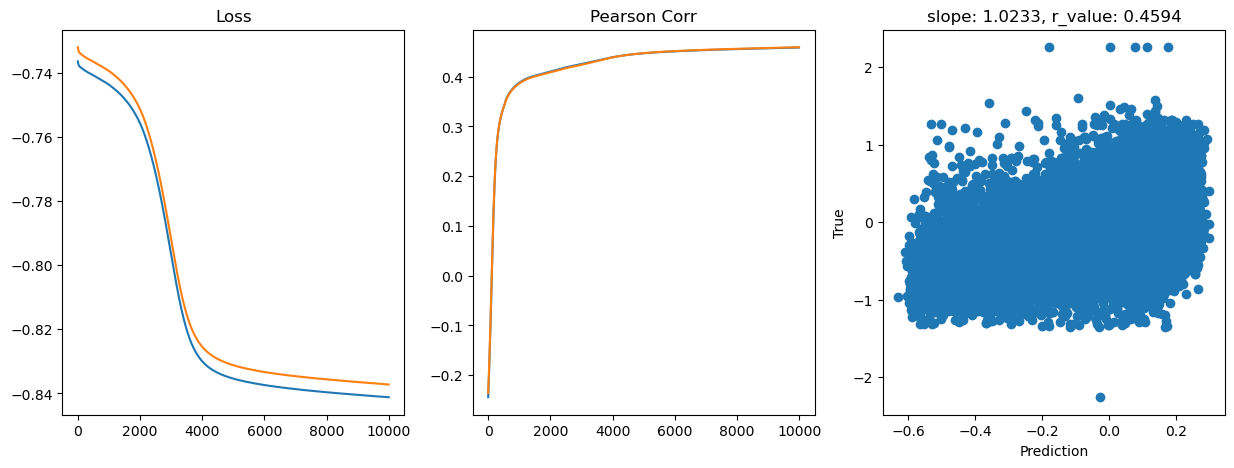


hid_dim: 128, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.1844, val_loss: 0.1855, r_value: -0.0339
Epoch 500, train_loss: 0.1709, val_loss: 0.1725, r_value: 0.4039
Epoch 1000, train_loss: 0.1479, val_loss: 0.1493, r_value: 0.4363
Epoch 1500, train_loss: 0.1458, val_loss: 0.1472, r_value: 0.4492
Epoch 2000, train_loss: 0.1446, val_loss: 0.1460, r_value: 0.4565
Epoch 2500, train_loss: 0.1437, val_loss: 0.1451, r_value: 0.4617
Epoch 3000, train_loss: 0.1431, val_loss: 0.1444, r_value: 0.4655
Epoch 3500, train_loss: 0.1425, val_loss: 0.1439, r_value: 0.4688
Epoch 4000, train_loss: 0.1419, val_loss: 0.1434, r_value: 0.4717
Epoch 4500, train_loss: 0.1414, val_loss: 0.1429, r_value: 0.4745
Epoch 5000, train_loss: 0.1409, val_loss: 0.1423, r_value: 0.4776
Epoch 5500, train_loss: 0.1411, val_loss: 0.1423, r_value: 0.4798
Epoch 6000, train_loss: 0.1408, val_loss: 0.1420, r_value: 0.4822
Epoch 6500, train_loss: 0.1404, val_loss: 0.1417, r_value: 0.4844
Epoch 7000, train_loss: 0.1401,

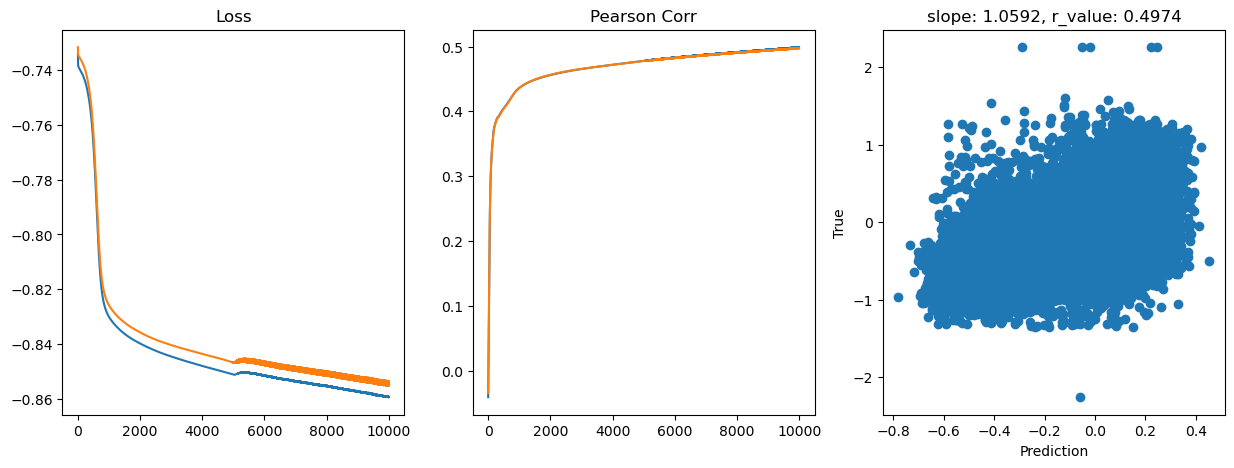


hid_dim: 256, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.1854, val_loss: 0.1890, r_value: -0.2486
Epoch 500, train_loss: 0.1587, val_loss: 0.1572, r_value: 0.4538
Epoch 1000, train_loss: 0.1548, val_loss: 0.1555, r_value: 0.4659
Epoch 1500, train_loss: 0.1518, val_loss: 0.1534, r_value: 0.4754
Epoch 2000, train_loss: 0.1495, val_loss: 0.1514, r_value: 0.4823
Epoch 2500, train_loss: 0.1474, val_loss: 0.1491, r_value: 0.4899
Epoch 3000, train_loss: 0.1412, val_loss: 0.1421, r_value: 0.4947
Epoch 3500, train_loss: 0.1550, val_loss: 0.1552, r_value: 0.4857
Epoch 4000, train_loss: 0.1420, val_loss: 0.1473, r_value: 0.4894
Epoch 4500, train_loss: 0.1353, val_loss: 0.1378, r_value: 0.5060
Epoch 5000, train_loss: 0.1425, val_loss: 0.1447, r_value: 0.5064
Epoch 5500, train_loss: 0.1410, val_loss: 0.1450, r_value: 0.5103
Epoch 6000, train_loss: 0.1360, val_loss: 0.1388, r_value: 0.5132
Epoch 6500, train_loss: 0.1369, val_loss: 0.1373, r_value: 0.5113
Epoch 7000, train_loss: 0.1404,

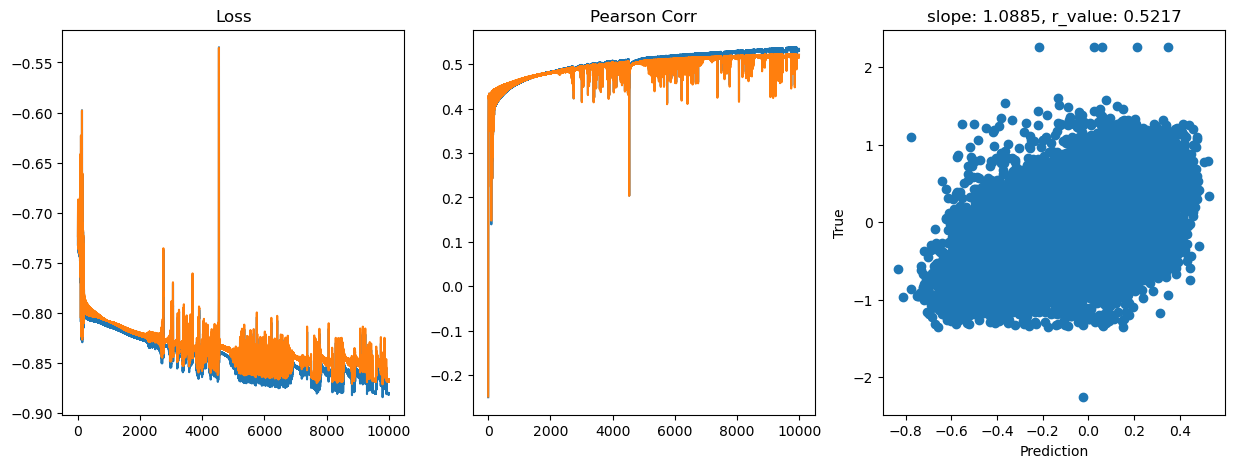


hid_dim: 256, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.1823, val_loss: 0.1839, r_value: 0.2372
Epoch 500, train_loss: 0.1497, val_loss: 0.1501, r_value: 0.4585
Epoch 1000, train_loss: 0.1461, val_loss: 0.1475, r_value: 0.4726
Epoch 1500, train_loss: 0.1438, val_loss: 0.1456, r_value: 0.4814
Epoch 2000, train_loss: 0.1425, val_loss: 0.1444, r_value: 0.4886
Epoch 2500, train_loss: 0.1411, val_loss: 0.1432, r_value: 0.4963
Epoch 3000, train_loss: 0.1396, val_loss: 0.1414, r_value: 0.5006
Epoch 3500, train_loss: 0.1413, val_loss: 0.1433, r_value: 0.5074
Epoch 4000, train_loss: 0.1374, val_loss: 0.1397, r_value: 0.5112
Epoch 4500, train_loss: 0.1379, val_loss: 0.1402, r_value: 0.5129
Epoch 5000, train_loss: 0.1371, val_loss: 0.1393, r_value: 0.5124
Epoch 5500, train_loss: 0.1339, val_loss: 0.1369, r_value: 0.5089
Epoch 6000, train_loss: 0.1360, val_loss: 0.1388, r_value: 0.5179
Epoch 6500, train_loss: 0.1366, val_loss: 0.1397, r_value: 0.5188
Epoch 7000, train_loss: 0.1368, v

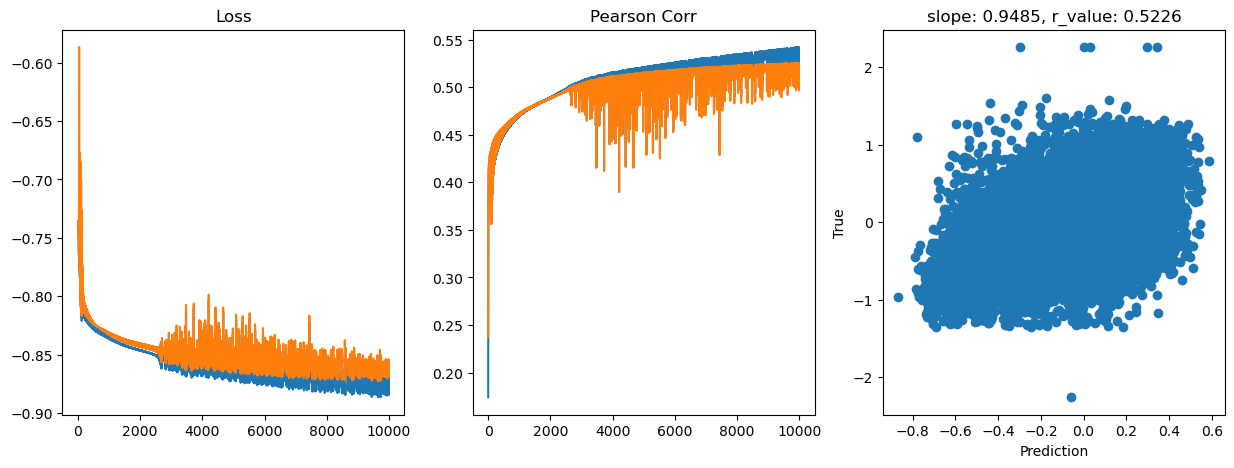


hid_dim: 256, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.1824, val_loss: 0.1841, r_value: 0.1137
Epoch 500, train_loss: 0.1458, val_loss: 0.1472, r_value: 0.4493
Epoch 1000, train_loss: 0.1450, val_loss: 0.1465, r_value: 0.4604
Epoch 1500, train_loss: 0.1440, val_loss: 0.1455, r_value: 0.4666
Epoch 2000, train_loss: 0.1432, val_loss: 0.1447, r_value: 0.4715
Epoch 2500, train_loss: 0.1423, val_loss: 0.1439, r_value: 0.4762
Epoch 3000, train_loss: 0.1416, val_loss: 0.1432, r_value: 0.4807
Epoch 3500, train_loss: 0.1409, val_loss: 0.1425, r_value: 0.4852
Epoch 4000, train_loss: 0.1402, val_loss: 0.1419, r_value: 0.4893
Epoch 4500, train_loss: 0.1395, val_loss: 0.1413, r_value: 0.4932
Epoch 5000, train_loss: 0.1389, val_loss: 0.1407, r_value: 0.4967
Epoch 5500, train_loss: 0.1383, val_loss: 0.1402, r_value: 0.4999
Epoch 6000, train_loss: 0.1376, val_loss: 0.1396, r_value: 0.5028
Epoch 6500, train_loss: 0.1370, val_loss: 0.1391, r_value: 0.5055
Epoch 7000, train_loss: 0.1365, v

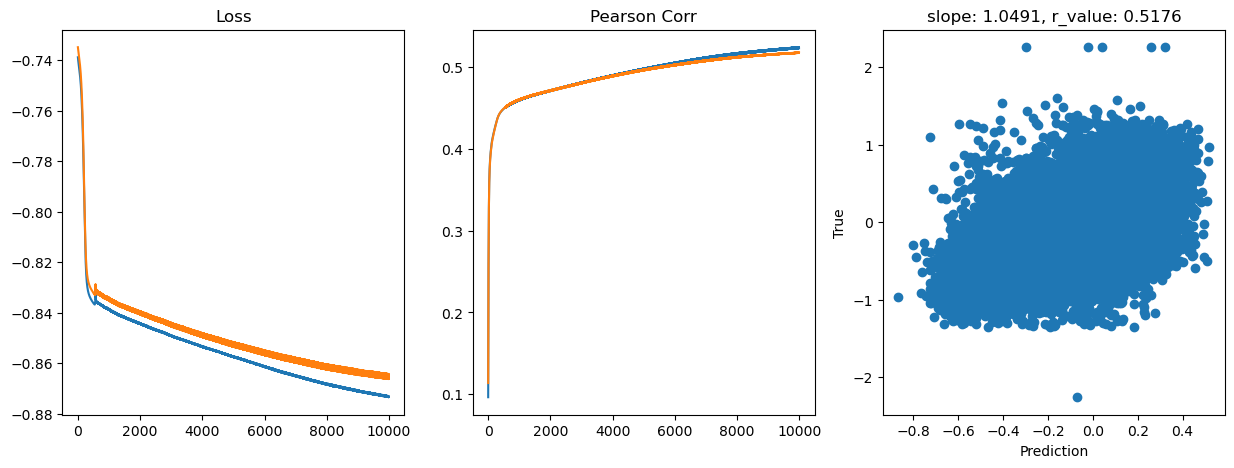


hid_dim: 256, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.1834, val_loss: 0.1850, r_value: -0.2138
Epoch 500, train_loss: 0.1808, val_loss: 0.1825, r_value: 0.4074
Epoch 1000, train_loss: 0.1779, val_loss: 0.1797, r_value: 0.4218
Epoch 1500, train_loss: 0.1725, val_loss: 0.1742, r_value: 0.4248
Epoch 2000, train_loss: 0.1624, val_loss: 0.1640, r_value: 0.4276
Epoch 2500, train_loss: 0.1521, val_loss: 0.1536, r_value: 0.4321
Epoch 3000, train_loss: 0.1481, val_loss: 0.1495, r_value: 0.4383
Epoch 3500, train_loss: 0.1469, val_loss: 0.1483, r_value: 0.4432
Epoch 4000, train_loss: 0.1463, val_loss: 0.1477, r_value: 0.4465
Epoch 4500, train_loss: 0.1459, val_loss: 0.1472, r_value: 0.4488
Epoch 5000, train_loss: 0.1456, val_loss: 0.1469, r_value: 0.4507
Epoch 5500, train_loss: 0.1453, val_loss: 0.1467, r_value: 0.4524
Epoch 6000, train_loss: 0.1451, val_loss: 0.1464, r_value: 0.4538
Epoch 6500, train_loss: 0.1448, val_loss: 0.1462, r_value: 0.4551
Epoch 7000, train_loss: 0.1447,

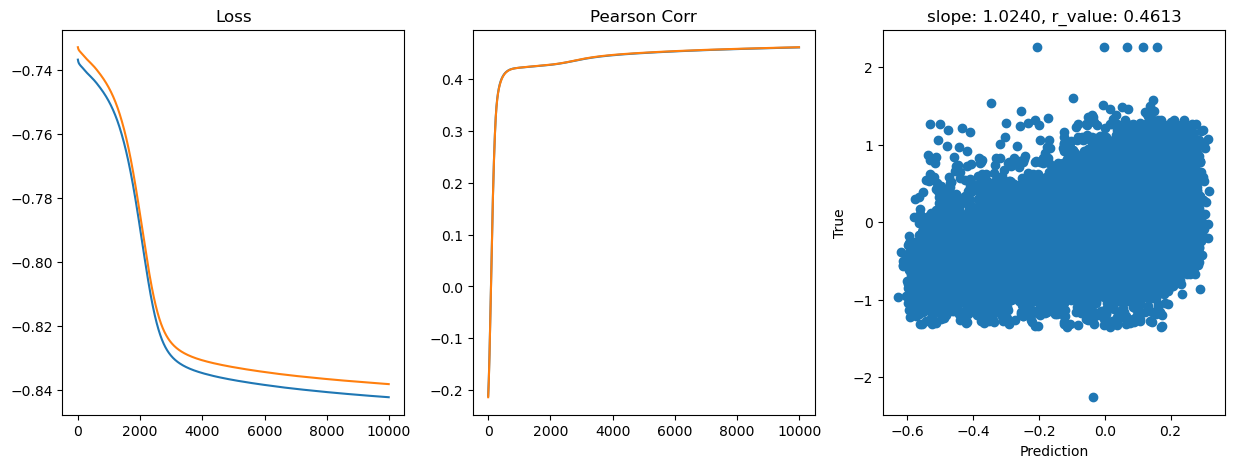


hid_dim: 256, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.1841, val_loss: 0.1851, r_value: 0.1820
Epoch 500, train_loss: 0.1507, val_loss: 0.1521, r_value: 0.4349
Epoch 1000, train_loss: 0.1456, val_loss: 0.1469, r_value: 0.4511
Epoch 1500, train_loss: 0.1443, val_loss: 0.1456, r_value: 0.4585
Epoch 2000, train_loss: 0.1435, val_loss: 0.1448, r_value: 0.4635
Epoch 2500, train_loss: 0.1428, val_loss: 0.1441, r_value: 0.4673
Epoch 3000, train_loss: 0.1422, val_loss: 0.1435, r_value: 0.4707
Epoch 3500, train_loss: 0.1416, val_loss: 0.1430, r_value: 0.4738
Epoch 4000, train_loss: 0.1416, val_loss: 0.1428, r_value: 0.4765
Epoch 4500, train_loss: 0.1413, val_loss: 0.1426, r_value: 0.4790
Epoch 5000, train_loss: 0.1409, val_loss: 0.1422, r_value: 0.4814
Epoch 5500, train_loss: 0.1406, val_loss: 0.1419, r_value: 0.4837
Epoch 6000, train_loss: 0.1401, val_loss: 0.1415, r_value: 0.4858
Epoch 6500, train_loss: 0.1398, val_loss: 0.1411, r_value: 0.4880
Epoch 7000, train_loss: 0.1394, 

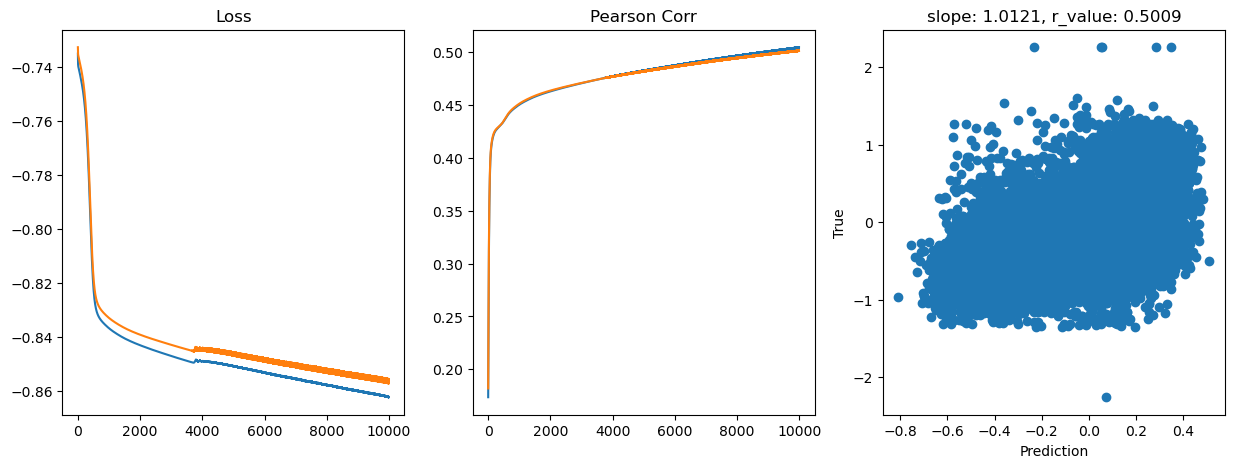


hid_dim: 512, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.1826, val_loss: 0.1840, r_value: 0.3779
Epoch 500, train_loss: 0.1557, val_loss: 0.1588, r_value: 0.4407
Epoch 1000, train_loss: 0.1528, val_loss: 0.1545, r_value: 0.4622
Epoch 1500, train_loss: 0.1502, val_loss: 0.1516, r_value: 0.4754
Epoch 2000, train_loss: 0.1483, val_loss: 0.1501, r_value: 0.4830
Epoch 2500, train_loss: 0.1478, val_loss: 0.1489, r_value: 0.4910
Epoch 3000, train_loss: 0.1453, val_loss: 0.1469, r_value: 0.4976
Epoch 3500, train_loss: 0.1421, val_loss: 0.1462, r_value: 0.4990
Epoch 4000, train_loss: 0.1363, val_loss: 0.1382, r_value: 0.5105
Epoch 4500, train_loss: 0.1368, val_loss: 0.1406, r_value: 0.5128
Epoch 5000, train_loss: 0.1421, val_loss: 0.1482, r_value: 0.4841
Epoch 5500, train_loss: 0.1372, val_loss: 0.1428, r_value: 0.5116
Epoch 6000, train_loss: 0.1416, val_loss: 0.1464, r_value: 0.5134
Epoch 6500, train_loss: 0.1405, val_loss: 0.1478, r_value: 0.4916
Epoch 7000, train_loss: 0.1385, 

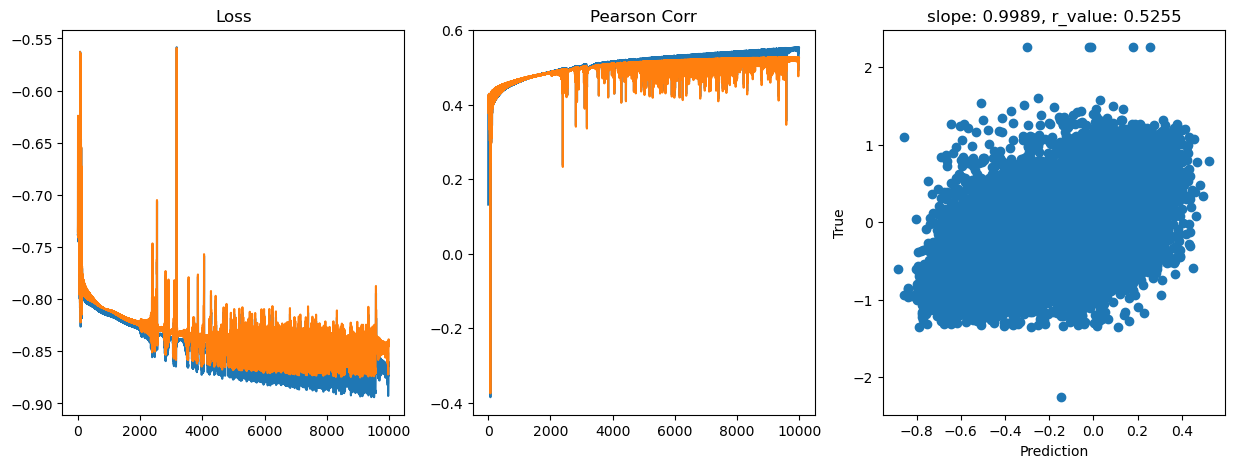


hid_dim: 512, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.1835, val_loss: 0.1845, r_value: 0.0661
Epoch 500, train_loss: 0.1480, val_loss: 0.1502, r_value: 0.4544
Epoch 1000, train_loss: 0.1449, val_loss: 0.1460, r_value: 0.4766
Epoch 1500, train_loss: 0.1425, val_loss: 0.1434, r_value: 0.4885
Epoch 2000, train_loss: 0.1417, val_loss: 0.1423, r_value: 0.4973
Epoch 2500, train_loss: 0.1392, val_loss: 0.1408, r_value: 0.5002
Epoch 3000, train_loss: 0.1384, val_loss: 0.1402, r_value: 0.5085
Epoch 3500, train_loss: 0.1363, val_loss: 0.1385, r_value: 0.5105
Epoch 4000, train_loss: 0.1372, val_loss: 0.1397, r_value: 0.5167
Epoch 4500, train_loss: 0.1359, val_loss: 0.1386, r_value: 0.5166
Epoch 5000, train_loss: 0.1355, val_loss: 0.1386, r_value: 0.5206
Epoch 5500, train_loss: 0.1326, val_loss: 0.1350, r_value: 0.5214
Epoch 6000, train_loss: 0.1313, val_loss: 0.1345, r_value: 0.5222
Epoch 6500, train_loss: 0.1336, val_loss: 0.1378, r_value: 0.5250
Epoch 7000, train_loss: 0.1341, v

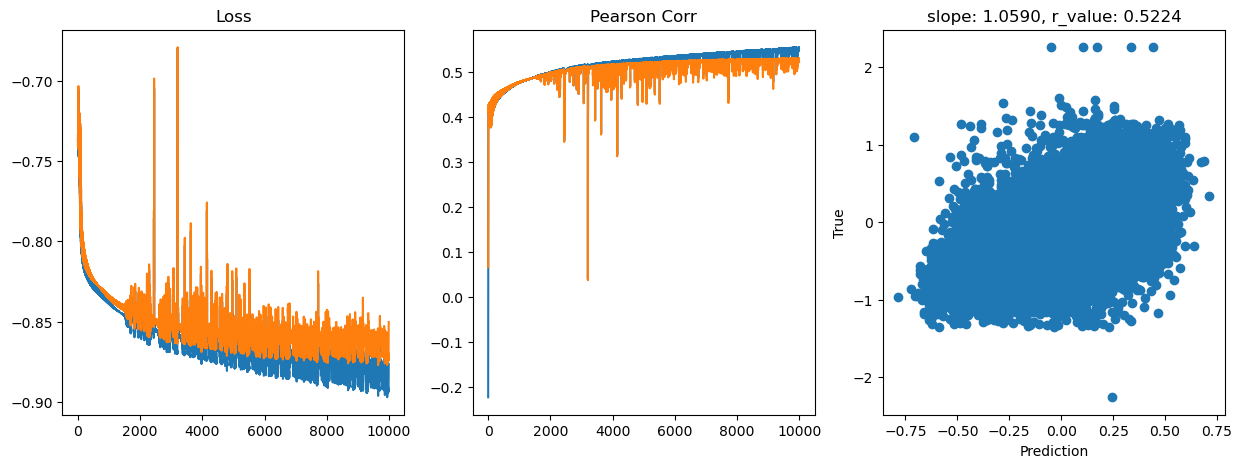


hid_dim: 512, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.1826, val_loss: 0.1842, r_value: 0.0892
Epoch 500, train_loss: 0.1468, val_loss: 0.1481, r_value: 0.4540
Epoch 1000, train_loss: 0.1445, val_loss: 0.1459, r_value: 0.4648
Epoch 1500, train_loss: 0.1431, val_loss: 0.1446, r_value: 0.4718
Epoch 2000, train_loss: 0.1421, val_loss: 0.1436, r_value: 0.4778
Epoch 2500, train_loss: 0.1411, val_loss: 0.1427, r_value: 0.4831
Epoch 3000, train_loss: 0.1403, val_loss: 0.1420, r_value: 0.4877
Epoch 3500, train_loss: 0.1396, val_loss: 0.1413, r_value: 0.4918
Epoch 4000, train_loss: 0.1389, val_loss: 0.1407, r_value: 0.4957
Epoch 4500, train_loss: 0.1382, val_loss: 0.1401, r_value: 0.4995
Epoch 5000, train_loss: 0.1375, val_loss: 0.1395, r_value: 0.5032
Epoch 5500, train_loss: 0.1369, val_loss: 0.1390, r_value: 0.5067
Epoch 6000, train_loss: 0.1362, val_loss: 0.1384, r_value: 0.5097
Epoch 6500, train_loss: 0.1356, val_loss: 0.1379, r_value: 0.5124
Epoch 7000, train_loss: 0.1350, v

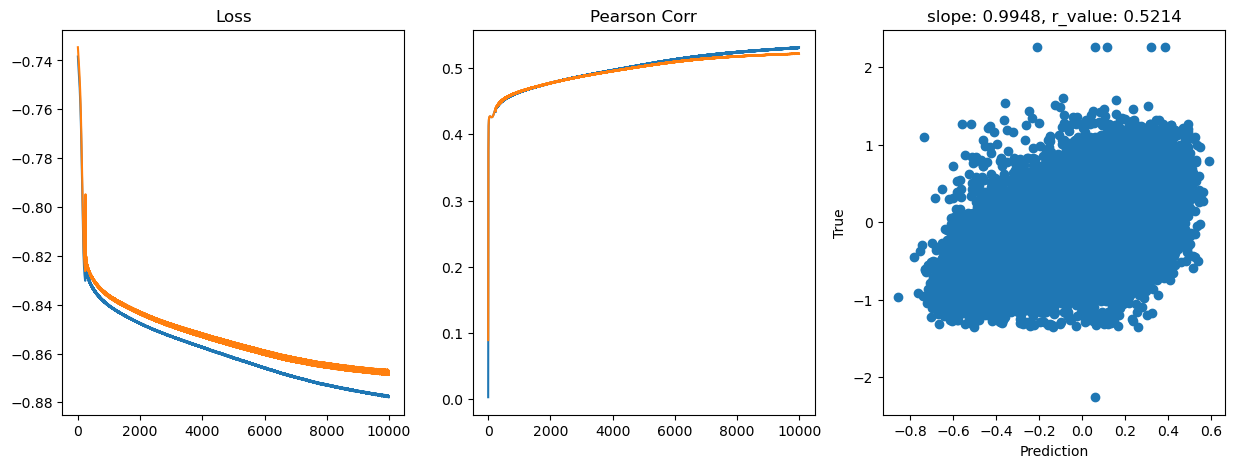


hid_dim: 512, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.1827, val_loss: 0.1845, r_value: -0.0949
Epoch 500, train_loss: 0.1791, val_loss: 0.1809, r_value: 0.4072
Epoch 1000, train_loss: 0.1732, val_loss: 0.1749, r_value: 0.4166
Epoch 1500, train_loss: 0.1618, val_loss: 0.1634, r_value: 0.4232
Epoch 2000, train_loss: 0.1512, val_loss: 0.1527, r_value: 0.4312
Epoch 2500, train_loss: 0.1477, val_loss: 0.1492, r_value: 0.4393
Epoch 3000, train_loss: 0.1466, val_loss: 0.1480, r_value: 0.4447
Epoch 3500, train_loss: 0.1460, val_loss: 0.1473, r_value: 0.4484
Epoch 4000, train_loss: 0.1455, val_loss: 0.1469, r_value: 0.4512
Epoch 4500, train_loss: 0.1451, val_loss: 0.1465, r_value: 0.4535
Epoch 5000, train_loss: 0.1448, val_loss: 0.1461, r_value: 0.4555
Epoch 5500, train_loss: 0.1445, val_loss: 0.1458, r_value: 0.4573
Epoch 6000, train_loss: 0.1442, val_loss: 0.1456, r_value: 0.4589
Epoch 6500, train_loss: 0.1440, val_loss: 0.1453, r_value: 0.4603
Epoch 7000, train_loss: 0.1438,

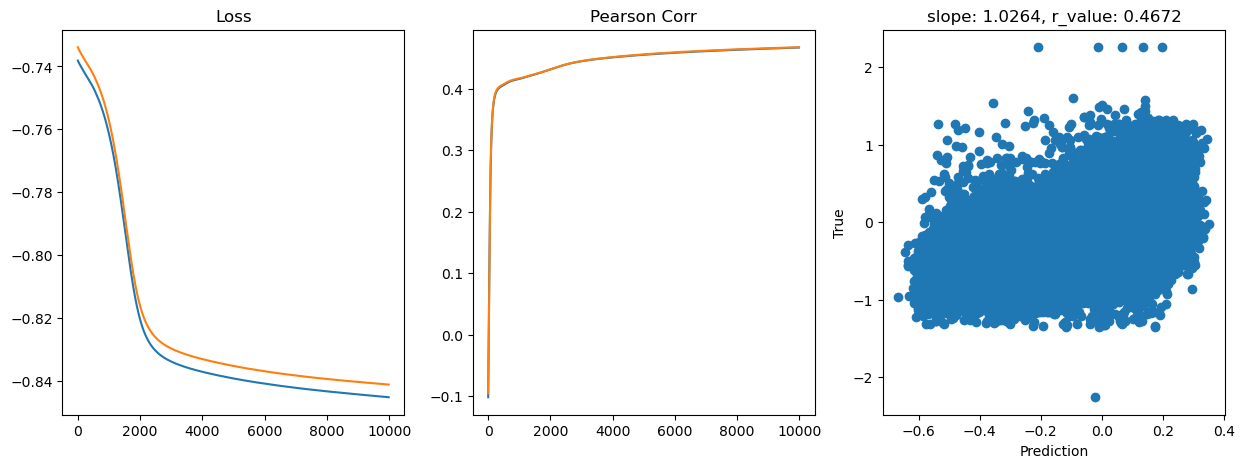


hid_dim: 512, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.1837, val_loss: 0.1852, r_value: 0.0732
Epoch 500, train_loss: 0.1470, val_loss: 0.1484, r_value: 0.4426
Epoch 1000, train_loss: 0.1447, val_loss: 0.1461, r_value: 0.4556
Epoch 1500, train_loss: 0.1437, val_loss: 0.1451, r_value: 0.4617
Epoch 2000, train_loss: 0.1430, val_loss: 0.1444, r_value: 0.4658
Epoch 2500, train_loss: 0.1424, val_loss: 0.1438, r_value: 0.4694
Epoch 3000, train_loss: 0.1423, val_loss: 0.1436, r_value: 0.4724
Epoch 3500, train_loss: 0.1419, val_loss: 0.1431, r_value: 0.4755
Epoch 4000, train_loss: 0.1414, val_loss: 0.1427, r_value: 0.4786
Epoch 4500, train_loss: 0.1409, val_loss: 0.1422, r_value: 0.4815
Epoch 5000, train_loss: 0.1404, val_loss: 0.1418, r_value: 0.4844
Epoch 5500, train_loss: 0.1399, val_loss: 0.1413, r_value: 0.4873
Epoch 6000, train_loss: 0.1394, val_loss: 0.1408, r_value: 0.4901
Epoch 6500, train_loss: 0.1390, val_loss: 0.1404, r_value: 0.4927
Epoch 7000, train_loss: 0.1385, 

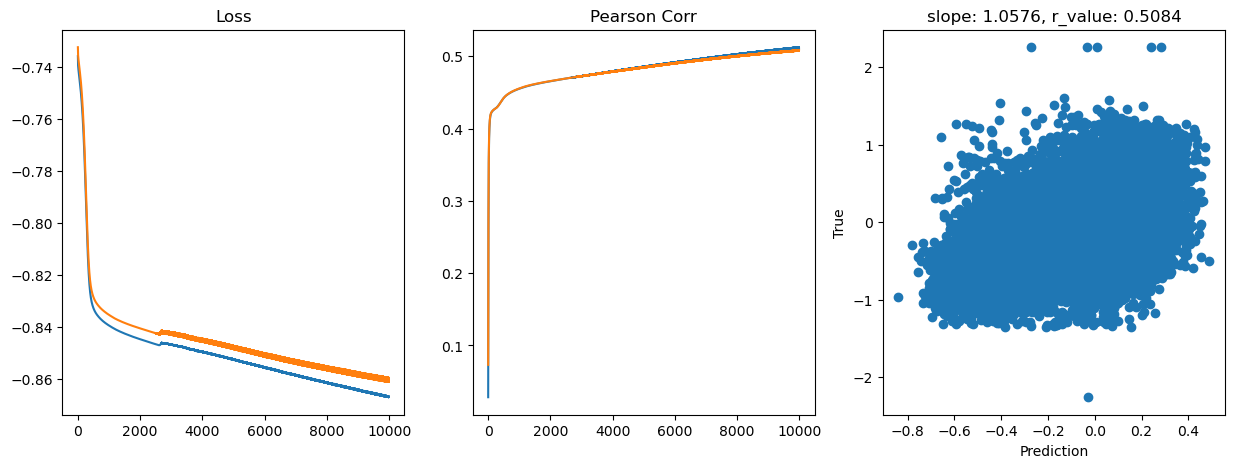

In [15]:
# model.train()
epoch = 10000
hid_dim_range = [128,256,512]
lr_range = [0.75,0.5,0.1,0.01,0.05]

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Feedforward(data.shape[1], hid_dim).to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        all_r_train=[]
        all_r_val=[]
        
        for epoch in range(epoch):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train.to(device))
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train.to(device))

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())
            y_pred = y_pred.cpu().detach().numpy().squeeze()
            _, _, r_value_train, _, _ = scipy.stats.linregress(y_pred, y_train)
            all_r_train.append(r_value_train)

            model.eval()
            with torch.no_grad():
                y_pred = model(X_test.to(device))
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test.to(device))
                all_loss_val.append(loss.item())
                
                y_pred = y_pred.cpu().detach().numpy().squeeze()
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                all_r_val.append(r_value)
            
                if epoch%500==0:
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,3,figsize=(15,5))
        ax[0].plot(np.log10(all_loss_train))
        ax[0].plot(np.log10(all_loss_val))
        ax[0].set_title('Loss')
        
        ax[1].plot(all_r_train)
        ax[1].plot(all_r_val)
        ax[1].set_title('Pearson Corr')

        ax[2].scatter(y_pred, y_test.cpu())
        ax[2].set_xlabel('Prediction')
        ax[2].set_ylabel('True')
        ax[2].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        
        plt.show()

In [15]:
# Let's try the sklearn MLP implementation
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=1000).fit(X_train, y_train)
print(regr)

MLPRegressor(max_iter=1000, random_state=1)


Text(0.5, 1.0, 'slope: 0.9208, r_value: 0.5133')

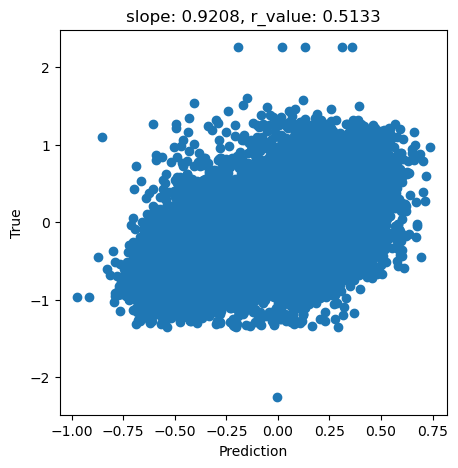

In [16]:
y_pred = regr.predict(X_test)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(y_pred, y_test.cpu())
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))

In [ ]:
regr = MLPRegressor(hidden_layer_sizes=(256,256,256),random_state=1, max_iter=1000).fit(X_train, y_train)

In [ ]:
y_pred = regr.predict(X_test)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(y_pred, y_test.cpu())
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))